# Giga Recurrent Unbounded Network ➿

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler
import wandb
from IPython.display import Markdown

## Data Preprocessing & Loading

### Dataset Preprocessing

In [2]:
DAY_IN_MINUTES = 287

EXCLUDE_FEATURES = [
    "Failure", "Frequency", "Status", "Others",
    "Code", "name", "deviceid", "serial",
    "SB0", "Phase", "NV10P", "TotalEnergy_QuotControl", "TotalEnergyImported"
    #"INV01_TotalEnergy", "INV02_TotalEnergy", "INV03_TotalEnergy",
    #"cos",
    #"sin",
    "state", "SOL", "NA16", 
    #'soil_moisture_7_to_28cm (m³/m³)',
]
PATH = "merged_annuale_meteo.csv"

In [3]:
df = pd.read_csv(PATH, delimiter = ";")
df['timestamp'] = pd.to_datetime(df['timestamp'], yearfirst=True)
cols_to_remove = [column  for column in df.columns if len([elem for elem in EXCLUDE_FEATURES if elem in column]) > 0]
df = df.drop(columns=cols_to_remove)

# aggiunta encoding ciclico minuti, giorni
tmp_datetime_serie = pd.to_datetime(arg=df['timestamp'], yearfirst=True)

df["minute_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)
df["minute_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)

df["day_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)
df["day_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)

# trasformo la target series in Non Cumulativa
df['target'] = df['Cont_TotalEnergy(kWh)'].diff().fillna(0)

In [4]:
df = df.set_index(df['timestamp'])

In [5]:
# resample in H
df = df.resample('H').sum()

In [6]:
df

INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
timestamp                                                     
2022-02-02 00:00:00             2440.68             2941.73   
2022-02-02 01:00:00             2662.56             3209.16   
2022-02-02 02:00:00             2662.56             3209.16   
2022-02-02 03:00:00             2662.56             3209.16   
2022-02-02 04:00:00             2662.56             3209.16   
...                                 ...                 ...   
2023-06-16 14:00:00                0.00                0.00   
2023-06-16 15:00:00                0.00                0.00   
2023-06-16 16:00:00                0.00                0.00   
2023-06-16 17:00:00                0.00                0.00   
2023-06-16 18:00:00                0.00                0.00   

                     INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  \
timestamp                                                        
2022-02-02 00:00:00             54843180.48            1326.93   
2022-02-02 01:00:00             59828924.16            1447.56   
2022-02-02 02:00:00             59828924.16            1447.56   
2022-02-02 03:00:00             59828924.16            1447.56   
2022-02-02 04:00:00             59828924.16            1447.56   
...                                     ...                ...   
2023-06-16 14:00:00                    0.00               0.00   
2023-06-16 15:00:00                    0.00               0.00   
2023-06-16 16:00:00                    0.00               0.00   
2023-06-16 17:00:00                    0.00               0.00   
2023-06-16 18:00:00                    0.00               0.00   

                     INV01_PowerDC(kW)  INV01_InternalTemperature(C)  \
timestamp                                                              
2022-02-02 00:00:00            1411.85                         195.8   
2022-02-02 01:00:00            1540.20                         213.6   
2022-02-02 02:00:00            1540.20                         213.6   
2022-02-02 03:00:00            1540.20                         213.6   
2022-02-02 04:00:00            1540.20                         213.6   
...                                ...                           ...   
2023-06-16 14:00:00               0.00                           0.0   
2023-06-16 15:00:00               0.00                           0.0   
2023-06-16 16:00:00               0.00                           0.0   
2023-06-16 17:00:00               0.00                           0.0   
2023-06-16 18:00:00               0.00                           0.0   

                     INV01_HeatSinkTemperature(C)  INV01_VoltageDC(V)  \
timestamp                                                               
2022-02-02 00:00:00                        535.81             6363.83   
2022-02-02 01:00:00                        584.52             6942.36   
2022-02-02 02:00:00                        584.52             6942.36   
2022-02-02 03:00:00                        584.52             6942.36   
2022-02-02 04:00:00                        584.52             6942.36   
...                                           ...                 ...   
2023-06-16 14:00:00                          0.00                0.00   
2023-06-16 15:00:00                          0.00                0.00   
2023-06-16 16:00:00                          0.00                0.00   
2023-06-16 17:00:00                          0.00                0.00   
2023-06-16 18:00:00                          0.00                0.00   

                     INV01_VoltageAC(V)  INV02_CurrentDC(A)  ...  \
timestamp                                                    ...   
2022-02-02 00:00:00             2873.75             2496.78  ...   
2022-02-02 01:00:00             3135.00             2723.76  ...   
2022-02-02 02:00:00             3135.00             2723.76  ...   
2022-02-02 03:00:00             3135.00             2723.76  ...   
2022-02-02 04:00:00             3135.00        

In [6]:
train_df = df[((df.index >= '2022-06-01') * (df.index < '2023-01-01'))]
val_df = df[((df.index >= '2023-01-01') * (df.index < '2023-02-01'))]
test_df = df[((df.index >= '2023-02-01') * (df.index < '2023-03-01'))]

In [7]:
train_scaler = MinMaxScaler()
train_scaler.fit(train_df)

#tmp_data = train_scaler.transform(train_df)
train_df = pd.DataFrame(train_scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
val_df = pd.DataFrame(train_scaler.transform(val_df), columns=val_df.columns, index=val_df.index)
test_df = pd.DataFrame(train_scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

train_target_scaler = MinMaxScaler()
train_target_scaler.fit(train_df['target'].to_numpy().reshape(-1, 1))

MinMaxScaler()

In [8]:
display(Markdown("### Training Dataframe"))
display(train_df)

display(Markdown("### Validation Dataframe"))
display(val_df)

display(Markdown("### Testing Dataframe"))
display(test_df)

### Training Dataframe

INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
timestamp                                                     
2022-06-01 00:00:00                 0.0                 0.0   
2022-06-01 01:00:00                 0.0                 0.0   
2022-06-01 02:00:00                 0.0                 0.0   
2022-06-01 03:00:00                 0.0                 0.0   
2022-06-01 04:00:00                 0.0                 0.0   
...                                 ...                 ...   
2022-12-31 19:00:00                 0.0                 0.0   
2022-12-31 20:00:00                 0.0                 0.0   
2022-12-31 21:00:00                 0.0                 0.0   
2022-12-31 22:00:00                 0.0                 0.0   
2022-12-31 23:00:00                 0.0                 0.0   

                     INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  \
timestamp                                                        
2022-06-01 00:00:00                0.000000                0.0   
2022-06-01 01:00:00                0.043725                0.0   
2022-06-01 02:00:00                0.043725                0.0   
2022-06-01 03:00:00                0.043725                0.0   
2022-06-01 04:00:00                0.043725                0.0   
...                                     ...                ...   
2022-12-31 19:00:00                1.000000                0.0   
2022-12-31 20:00:00                1.000000                0.0   
2022-12-31 21:00:00                1.000000                0.0   
2022-12-31 22:00:00                1.000000                0.0   
2022-12-31 23:00:00                1.000000                0.0   

                     INV01_PowerDC(kW)  INV01_InternalTemperature(C)  \
timestamp                                                              
2022-06-01 00:00:00                0.0                           0.0   
2022-06-01 01:00:00                0.0                           0.0   
2022-06-01 02:00:00                0.0                           0.0   
2022-06-01 03:00:00                0.0                           0.0   
2022-06-01 04:00:00                0.0                           0.0   
...                                ...                           ...   
2022-12-31 19:00:00                0.0                           0.0   
2022-12-31 20:00:00                0.0                           0.0   
2022-12-31 21:00:00                0.0                           0.0   
2022-12-31 22:00:00                0.0                           0.0   
2022-12-31 23:00:00                0.0                           0.0   

                     INV01_HeatSinkTemperature(C)  INV01_VoltageDC(V)  \
timestamp                                                               
2022-06-01 00:00:00                           0.0                 0.0   
2022-06-01 01:00:00                           0.0                 0.0   
2022-06-01 02:00:00                           0.0                 0.0   
2022-06-01 03:00:00                           0.0                 0.0   
2022-06-01 04:00:00                           0.0                 0.0   
...                                           ...                 ...   
2022-12-31 19:00:00                           0.0                 0.0   
2022-12-31 20:00:00                           0.0                 0.0   
2022-12-31 21:00:00                           0.0                 0.0   
2022-12-31 22:00:00                           0.0                 0.0   
2022-12-31 23:00:00                           0.0                 0.0   

                     INV01_VoltageAC(V)  INV02_CurrentDC(A)  ...  \
timestamp                                                    ...   
2022-06-01 00:00:00                 0.0                 0.0  ...   
2022-06-01 01:00:00                 0.0                 0.0  ...   
2022-06-01 02:00:00                 0.0                 0.0  ...   
2022-06-01 03:00:00                 0.0                 0.0  ...   
2022-06-01 04:00:00                 0.0        

### Validation Dataframe

INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
timestamp                                                     
2023-01-01 00:00:00                 0.0                 0.0   
2023-01-01 01:00:00                 0.0                 0.0   
2023-01-01 02:00:00                 0.0                 0.0   
2023-01-01 03:00:00                 0.0                 0.0   
2023-01-01 04:00:00                 0.0                 0.0   
...                                 ...                 ...   
2023-01-31 19:00:00                 0.0                 0.0   
2023-01-31 20:00:00                 0.0                 0.0   
2023-01-31 21:00:00                 0.0                 0.0   
2023-01-31 22:00:00                 0.0                 0.0   
2023-01-31 23:00:00                 0.0                 0.0   

                     INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  \
timestamp                                                        
2023-01-01 00:00:00                0.876586                0.0   
2023-01-01 01:00:00                1.000000                0.0   
2023-01-01 02:00:00                1.000000                0.0   
2023-01-01 03:00:00                1.000000                0.0   
2023-01-01 04:00:00                1.000000                0.0   
...                                     ...                ...   
2023-01-31 19:00:00                1.074275                0.0   
2023-01-31 20:00:00                1.074275                0.0   
2023-01-31 21:00:00                1.074275                0.0   
2023-01-31 22:00:00                1.074275                0.0   
2023-01-31 23:00:00                1.074275                0.0   

                     INV01_PowerDC(kW)  INV01_InternalTemperature(C)  \
timestamp                                                              
2023-01-01 00:00:00                0.0                           0.0   
2023-01-01 01:00:00                0.0                           0.0   
2023-01-01 02:00:00                0.0                           0.0   
2023-01-01 03:00:00                0.0                           0.0   
2023-01-01 04:00:00                0.0                           0.0   
...                                ...                           ...   
2023-01-31 19:00:00                0.0                           0.0   
2023-01-31 20:00:00                0.0                           0.0   
2023-01-31 21:00:00                0.0                           0.0   
2023-01-31 22:00:00                0.0                           0.0   
2023-01-31 23:00:00                0.0                           0.0   

                     INV01_HeatSinkTemperature(C)  INV01_VoltageDC(V)  \
timestamp                                                               
2023-01-01 00:00:00                           0.0                 0.0   
2023-01-01 01:00:00                           0.0                 0.0   
2023-01-01 02:00:00                           0.0                 0.0   
2023-01-01 03:00:00                           0.0                 0.0   
2023-01-01 04:00:00                           0.0                 0.0   
...                                           ...                 ...   
2023-01-31 19:00:00                           0.0                 0.0   
2023-01-31 20:00:00                           0.0                 0.0   
2023-01-31 21:00:00                           0.0                 0.0   
2023-01-31 22:00:00                           0.0                 0.0   
2023-01-31 23:00:00                           0.0                 0.0   

                     INV01_VoltageAC(V)  INV02_CurrentDC(A)  ...  \
timestamp                                                    ...   
2023-01-01 00:00:00                 0.0                 0.0  ...   
2023-01-01 01:00:00                 0.0                 0.0  ...   
2023-01-01 02:00:00                 0.0                 0.0  ...   
2023-01-01 03:00:00                 0.0                 0.0  ...   
2023-01-01 04:00:00                 0.0        

### Testing Dataframe

INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
timestamp                                                     
2023-02-01 00:00:00              0.0000            0.000000   
2023-02-01 01:00:00              0.0000            0.000000   
2023-02-01 02:00:00              0.0000            0.000000   
2023-02-01 03:00:00              0.0000            0.000000   
2023-02-01 04:00:00              0.0000            0.000000   
...                                 ...                 ...   
2023-02-28 19:00:00              0.3631            0.427644   
2023-02-28 20:00:00              0.3631            0.427644   
2023-02-28 21:00:00              0.3631            0.427644   
2023-02-28 22:00:00              0.3631            0.427644   
2023-02-28 23:00:00              0.3631            0.427644   

                     INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  \
timestamp                                                        
2023-02-01 00:00:00                0.944671           0.000000   
2023-02-01 01:00:00                1.074275           0.000000   
2023-02-01 02:00:00                1.074275           0.000000   
2023-02-01 03:00:00                1.074275           0.000000   
2023-02-01 04:00:00                1.074275           0.000000   
...                                     ...                ...   
2023-02-28 19:00:00                1.182526           0.424893   
2023-02-28 20:00:00                1.182526           0.424893   
2023-02-28 21:00:00                1.182526           0.424893   
2023-02-28 22:00:00                1.182526           0.424893   
2023-02-28 23:00:00                1.182526           0.424893   

                     INV01_PowerDC(kW)  INV01_InternalTemperature(C)  \
timestamp                                                              
2023-02-01 00:00:00           0.000000                      0.000000   
2023-02-01 01:00:00           0.000000                      0.000000   
2023-02-01 02:00:00           0.000000                      0.000000   
2023-02-01 03:00:00           0.000000                      0.000000   
2023-02-01 04:00:00           0.000000                      0.000000   
...                                ...                           ...   
2023-02-28 19:00:00           0.430938                      0.493144   
2023-02-28 20:00:00           0.430938                      0.493144   
2023-02-28 21:00:00           0.430938                      0.493144   
2023-02-28 22:00:00           0.430938                      0.493144   
2023-02-28 23:00:00           0.430938                      0.493144   

                     INV01_HeatSinkTemperature(C)  INV01_VoltageDC(V)  \
timestamp                                                               
2023-02-01 00:00:00                      0.000000             0.00000   
2023-02-01 01:00:00                      0.000000             0.00000   
2023-02-01 02:00:00                      0.000000             0.00000   
2023-02-01 03:00:00                      0.000000             0.00000   
2023-02-01 04:00:00                      0.000000             0.00000   
...                                           ...                 ...   
2023-02-28 19:00:00                      0.767313             0.83682   
2023-02-28 20:00:00                      0.767313             0.83682   
2023-02-28 21:00:00                      0.767313             0.83682   
2023-02-28 22:00:00                      0.767313             0.83682   
2023-02-28 23:00:00                      0.767313             0.83682   

                     INV01_VoltageAC(V)  INV02_CurrentDC(A)  ...  \
timestamp                                                    ...   
2023-02-01 00:00:00            0.000000                 0.0  ...   
2023-02-01 01:00:00            0.000000                 0.0  ...   
2023-02-01 02:00:00            0.000000                 0.0  ...   
2023-02-01 03:00:00            0.000000                 0.0  ...   
2023-02-01 04:00:00            0.000000        

### Dataset & DataLoader

In [9]:
BATCH_SIZE = 10

In [10]:
class CustomDataset(Dataset):
    MAX_DAYS = 4
    MIN_DAYS = 1
    DAY_IN_TIMESTAMPS = 24

    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        self.counter = 0
        self.target_len = -1
    
    def __len__(self):
        return int(len(self.df)/self.DAY_IN_TIMESTAMPS)-2 - self.MAX_DAYS
    
    def __getitem__(self, idx):
        if self.counter == self.batch_size:
            self.counter = 0
        
        if self.counter == 0:
            self.target_len = np.random.randint(1, self.MAX_DAYS+1)
        
        tmp_df = self.df.iloc[0+(self.DAY_IN_TIMESTAMPS*(idx+1)) - self.DAY_IN_TIMESTAMPS : (self.DAY_IN_TIMESTAMPS*(idx+1))+(self.DAY_IN_TIMESTAMPS*self.target_len) + self.DAY_IN_TIMESTAMPS]
        timestamps = tmp_df.index
        #timestamps = tmp_df['timestamp']
        #tmp_df = tmp_df.drop(columns=['timestamp'])

        mask_before = np.array([1]*self.DAY_IN_TIMESTAMPS + [0]*(len(tmp_df) - self.DAY_IN_TIMESTAMPS))
        mask_after = np.array([0] * (len(tmp_df) - self.DAY_IN_TIMESTAMPS) + [1]*self.DAY_IN_TIMESTAMPS)
        mask_target = np.array([0]*self.DAY_IN_TIMESTAMPS + [1] * (len(tmp_df) - self.DAY_IN_TIMESTAMPS*2) +[0] * self.DAY_IN_TIMESTAMPS)
        
        # print(len(mask_target), f"{timestamps[0]}-{timestamps[-1]}")
        
        before = tmp_df[mask_before == 1]
        target = tmp_df[mask_target == 1]
        after  = tmp_df[mask_after == 1]
        
        future = target.copy()
        future = future[[
            'Impianto_SolargisGHI(W/m2)','Impianto_SolargisGTI(W/m2)', 
            'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'day_sin', 'day_cos',
            'temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)', 
            'rain (mm)', 'cloudcover (%)', 'soil_temperature_7_to_28cm (°C)', 'soil_moisture_7_to_28cm (m³/m³)'
        ]]
        
        target = target['target']
        
        self.counter += 1
        
        #print(mask_before)
        #print(mask_target)
        #print(mask_after)
        
        return before, target, future, after, mask_before, mask_target, mask_after, timestamps
    
    def reset(self):
        self.counter = 0

In [11]:
def collate_fn(batch):
    # ha senso usare del padding ??
    before, target, future, after, masks_before, masks_target, masks_after, timestamps = zip(*batch)
    
    before = [torch.tensor(d.values, dtype=torch.float32) for d in before]
    before = torch.stack(before)
    
    target = [torch.tensor(d.values, dtype=torch.float32) for d in target]
    target = [torch.reshape(d, (d.shape[0], 1)) for d in target] # voglio shape [len_buco, 1]
    target = torch.stack(target)
    
    future = [torch.tensor(d.values, dtype=torch.float32) for d in future]
    future = torch.stack(future)
    
    after = [torch.tensor(d.values, dtype=torch.float32) for d in after]
    after = torch.stack(after)
    
    return before, target, future, after, masks_before, masks_target, masks_after, timestamps

### Tests

In [16]:
train_dataset = CustomDataset(train_df, BATCH_SIZE)

In [17]:
len(train_dataset)

208

In [18]:
b, t, f, a, mask_b, mask_t, mask_a, timestamps = train_dataset[0]

print(len(mask_b), len(mask_t), len(mask_a))

display(Markdown("### Before"))
display(b)
display(Markdown("### Target"))
display(t)
display(Markdown("### Future"))
display(f)
display(Markdown("### After"))
display(a)
display(Markdown("### Timestamps"))
display(timestamps)


144 144 144


### Before

INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
timestamp                                                     
2022-06-01 00:00:00                0.00                0.00   
2022-06-01 01:00:00                0.00                0.00   
2022-06-01 02:00:00                0.00                0.00   
2022-06-01 03:00:00                0.00                0.00   
2022-06-01 04:00:00                0.00                0.00   
2022-06-01 05:00:00                0.95                1.06   
2022-06-01 06:00:00              268.89              275.15   
2022-06-01 07:00:00              968.11             1174.71   
2022-06-01 08:00:00             2207.78             2697.36   
2022-06-01 09:00:00             3481.16             4097.15   
2022-06-01 10:00:00             4527.25             5148.70   
2022-06-01 11:00:00             5252.41             5732.65   
2022-06-01 12:00:00             5596.53             6067.50   
2022-06-01 13:00:00             5545.80             6051.86   
2022-06-01 14:00:00             5087.90             5636.46   
2022-06-01 15:00:00             4300.63             4845.24   
2022-06-01 16:00:00             3185.16             3684.83   
2022-06-01 17:00:00             1883.90             2222.13   
2022-06-01 18:00:00              693.79              779.34   
2022-06-01 19:00:00              187.72              165.35   
2022-06-01 20:00:00                0.85                0.75   
2022-06-01 21:00:00                0.00                0.00   
2022-06-01 22:00:00                0.00                0.00   
2022-06-01 23:00:00                0.00                0.00   

                     INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  \
timestamp                                                        
2022-06-01 00:00:00              1600687.88               0.00   
2022-06-01 01:00:00              1746204.96               0.00   
2022-06-01 02:00:00              1746204.96               0.00   
2022-06-01 03:00:00              1746204.96               0.00   
2022-06-01 04:00:00              1746204.96               0.00   
2022-06-01 05:00:00              1746204.96               0.38   
2022-06-01 06:00:00              1746249.62             116.10   
2022-06-01 07:00:00              1746528.15             515.06   
2022-06-01 08:00:00              1747374.68            1189.62   
2022-06-01 09:00:00              1748889.44            1815.99   
2022-06-01 10:00:00              1750952.67            2279.38   
2022-06-01 11:00:00              1753393.78            2571.10   
2022-06-01 12:00:00              1756052.77            2719.22   
2022-06-01 13:00:00              1758780.94            2701.48   
2022-06-01 14:00:00              1761403.30            2515.27   
2022-06-01 15:00:00              1763758.06            2161.14   
2022-06-01 16:00:00              1765673.07            1640.07   
2022-06-01 17:00:00              1766994.39             984.05   
2022-06-01 18:00:00              1767642.55             341.27   
2022-06-01 19:00:00              1767810.24              65.59   
2022-06-01 20:00:00              1767836.16               0.22   
2022-06-01 21:00:00              1767836.16               0.00   
2022-06-01 22:00:00              1767836.16               0.00   
2022-06-01 23:00:00              1767836.16               0.00   

                     INV01_PowerDC(kW)  INV01_InternalTemperature(C)  \
timestamp                                                              
2022-06-01 00:00:00               0.00                          0.00   
2022-06-01 01:00:00               0.00                          0.00   
2022-06-01 02:00:00               0.00                          0.00   
2022-06-01 03:00:00               0.00                          0.00   
2022-06-01 04:00:00               0.00                          0.00   
2022-06-01 05:00:00               0.55                        272.75   
2022-06-01 06:00:00             138.42                        299.46   
2022-06-01 07:00:

### Target

timestamp
2022-06-02 00:00:00     0.0
2022-06-02 01:00:00     0.0
2022-06-02 02:00:00     0.0
2022-06-02 03:00:00     0.0
2022-06-02 04:00:00     0.0
                       ... 
2022-06-05 19:00:00    40.5
2022-06-05 20:00:00     0.0
2022-06-05 21:00:00     0.0
2022-06-05 22:00:00     0.0
2022-06-05 23:00:00     0.0
Freq: H, Name: target, Length: 96, dtype: float64

### Future

Impianto_SolargisGHI(W/m2)  Impianto_SolargisGTI(W/m2)  \
timestamp                                                                     
2022-06-02 00:00:00                         0.0                         0.0   
2022-06-02 01:00:00                         0.0                         0.0   
2022-06-02 02:00:00                         0.0                         0.0   
2022-06-02 03:00:00                         0.0                         0.0   
2022-06-02 04:00:00                         0.0                         0.0   
...                                         ...                         ...   
2022-06-05 19:00:00                       925.0                       680.0   
2022-06-05 20:00:00                        61.0                        52.0   
2022-06-05 21:00:00                         0.0                         0.0   
2022-06-05 22:00:00                         0.0                         0.0   
2022-06-05 23:00:00                         0.0                         0.0   

                        month_sin  month_cos   hour_sin   hour_cos  \
timestamp                                                            
2022-06-02 00:00:00  1.347111e-15      -11.0   0.000000  11.000000   
2022-06-02 01:00:00  1.469576e-15      -12.0   3.105829  11.591110   
2022-06-02 02:00:00  1.469576e-15      -12.0   6.000000  10.392305   
2022-06-02 03:00:00  1.469576e-15      -12.0   8.485281   8.485281   
2022-06-02 04:00:00  1.469576e-15      -12.0  10.392305   6.000000   
...                           ...        ...        ...        ...   
2022-06-05 19:00:00  1.469576e-15      -12.0 -11.591110   3.105829   
2022-06-05 20:00:00  1.469576e-15      -12.0 -10.392305   6.000000   
2022-06-05 21:00:00  1.469576e-15      -12.0  -8.485281   8.485281   
2022-06-05 22:00:00  1.469576e-15      -12.0  -6.000000  10.392305   
2022-06-05 23:00:00  1.469576e-15      -12.0  -3.105829  11.591110   

                       minute_sin    minute_cos    day_sin    day_cos  \
timestamp                                                               
2022-06-02 00:00:00  1.609823e-15 -1.000000e+00   4.337914  10.108536   
2022-06-02 01:00:00  1.609823e-15  5.551115e-16   4.732270  11.027494   
2022-06-02 02:00:00  1.609823e-15  5.551115e-16   4.732270  11.027494   
2022-06-02 03:00:00  1.609823e-15  5.551115e-16   4.732270  11.027494   
2022-06-02 04:00:00  1.609823e-15  5.551115e-16   4.732270  11.027494   
...                           ...           ...        ...        ...   
2022-06-05 19:00:00  1.609823e-15  5.551115e-16  10.183731   6.347568   
2022-06-05 20:00:00  1.609823e-15  5.551115e-16  10.183731   6.347568   
2022-06-05 21:00:00  1.609823e-15  5.551115e-16  10.183731   6.347568   
2022-06-05 22:00:00  1.609823e-15  5.551115e-16  10.183731   6.347568   
2022-06-05 23:00:00  1.609823e-15  5.551115e-16  10.183731   6.347568   

                     temperature_2m (°C)  relativehumidity_2m (%)  \
timestamp                                                           
2022-06-02 00:00:00                218.9                    902.0   
2022-06-02 01:00:00                243.2                    951.0   
2022-06-02 02:00:00                244.7                    948.0   
2022-06-02 03:00:00                243.7                    948.0   
2022-06-02 04:00:00                243.6                    948.0   
...                                  ...                      ...   
2022-06-05 19:00:00                338.6                    576.0   
2022-06-05 20:00:00                309.8                    752.0   
2022-06-05 21:00:00                299.5                    801.0   
2022-06-05 22:00:00                299.9                    793.0   
2022-06-05 23:00:00                298.9                    704.0   

                     dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
timestamp                                                          
2022-06-02 00:00:00             184.8        0.0             0.0   
2022-06-02 01:00:00           

### After

INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
timestamp                                                     
2022-06-06 00:00:00                0.00                0.00   
2022-06-06 01:00:00                0.00                0.00   
2022-06-06 02:00:00                0.00                0.00   
2022-06-06 03:00:00                0.00                0.00   
2022-06-06 04:00:00                0.00                0.00   
2022-06-06 05:00:00                0.00                0.00   
2022-06-06 06:00:00              303.56              321.98   
2022-06-06 07:00:00              927.75             1092.78   
2022-06-06 08:00:00             2108.69             2519.59   
2022-06-06 09:00:00             3322.34             3885.43   
2022-06-06 10:00:00             4359.53             4951.92   
2022-06-06 11:00:00             5076.61             5596.39   
2022-06-06 12:00:00             5442.20             5915.65   
2022-06-06 13:00:00             5377.31             5798.96   
2022-06-06 14:00:00             4888.07             5341.02   
2022-06-06 15:00:00             4044.55             4520.89   
2022-06-06 16:00:00             3054.88             3499.50   
2022-06-06 17:00:00             1678.40             1943.87   
2022-06-06 18:00:00              720.30              795.87   
2022-06-06 19:00:00              285.15              265.43   
2022-06-06 20:00:00               23.51               19.95   
2022-06-06 21:00:00                0.00                0.00   
2022-06-06 22:00:00                0.00                0.00   
2022-06-06 23:00:00                0.00                0.00   

                     INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  \
timestamp                                                        
2022-06-06 00:00:00              1693371.46               0.00   
2022-06-06 01:00:00              1847314.32               0.00   
2022-06-06 02:00:00              1847314.32               0.00   
2022-06-06 03:00:00              1847314.32               0.00   
2022-06-06 04:00:00              1847314.32               0.00   
2022-06-06 05:00:00              1847314.32               0.00   
2022-06-06 06:00:00              1847361.48             137.91   
2022-06-06 07:00:00              1847654.37             477.24   
2022-06-06 08:00:00              1848436.18            1104.33   
2022-06-06 09:00:00              1849850.21            1707.22   
2022-06-06 10:00:00              1851809.62            2181.47   
2022-06-06 11:00:00              1854156.64            2480.56   
2022-06-06 12:00:00              1856728.52            2633.57   
2022-06-06 13:00:00              1859354.70            2587.58   
2022-06-06 14:00:00              1861867.04            2390.19   
2022-06-06 15:00:00              1864076.22            2018.06   
2022-06-06 16:00:00              1865882.00            1555.28   
2022-06-06 17:00:00              1867077.16             857.16   
2022-06-06 18:00:00              1867667.25             346.45   
2022-06-06 19:00:00              1867882.02             112.18   
2022-06-06 20:00:00              1867937.91               6.85   
2022-06-06 21:00:00              1867938.36               0.00   
2022-06-06 22:00:00              1867938.36               0.00   
2022-06-06 23:00:00              1867938.36               0.00   

                     INV01_PowerDC(kW)  INV01_InternalTemperature(C)  \
timestamp                                                              
2022-06-06 00:00:00               0.00                          0.00   
2022-06-06 01:00:00               0.00                          0.00   
2022-06-06 02:00:00               0.00                          0.00   
2022-06-06 03:00:00               0.00                          0.00   
2022-06-06 04:00:00               0.00                          0.00   
2022-06-06 05:00:00               0.00                        295.91   
2022-06-06 06:00:00             159.83                        339.06   
2022-06-06 07:00:

### Timestamps

DatetimeIndex(['2022-06-01 00:00:00', '2022-06-01 01:00:00',
               '2022-06-01 02:00:00', '2022-06-01 03:00:00',
               '2022-06-01 04:00:00', '2022-06-01 05:00:00',
               '2022-06-01 06:00:00', '2022-06-01 07:00:00',
               '2022-06-01 08:00:00', '2022-06-01 09:00:00',
               ...
               '2022-06-06 14:00:00', '2022-06-06 15:00:00',
               '2022-06-06 16:00:00', '2022-06-06 17:00:00',
               '2022-06-06 18:00:00', '2022-06-06 19:00:00',
               '2022-06-06 20:00:00', '2022-06-06 21:00:00',
               '2022-06-06 22:00:00', '2022-06-06 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=144, freq='H')

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

In [14]:
for b_before, b_target, b_future, b_after, b_m_b, b_m_t, b_m_a, b_timestamps in train_dataloader:
    print(b_before.shape, b_target.shape, b_future.shape, b_after.shape)
train_dataset.reset()

torch.Size([10, 287, 47]) torch.Size([10, 1148, 1]) torch.Size([10, 1148, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 287, 1]) torch.Size([10, 287, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 1148, 1]) torch.Size([10, 1148, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 1148, 1]) torch.Size([10, 1148, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 1148, 1]) torch.Size([10, 1148, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 287, 1]) torch.Size([10, 287, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 287, 1]) torch.Size([10, 287, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 861, 1]) torch.Size([10, 861, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 861, 1]) torch.Size([10, 861, 17]) torch.Size([10, 287, 47])
torch.Size([10, 287, 47]) torch.Size([10, 861, 1]) torch.Size([10

In [12]:
val_dataset = CustomDataset(val_df, BATCH_SIZE)

In [13]:
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

In [17]:
for b_vbefore, b_vtarget, b_vafter, b_vm_b, b_vm_t, b_vm_a, b_vtimestamps in val_dl:
    print(b_vbefore.shape, b_vtarget.shape, b_vafter.shape)
    print()
    #display(b_timestamps[0])

1148 2023-01-01 00:05:00-2023-01-04 23:55:00
1148 2023-01-09 00:05:00-2023-01-12 23:55:00
1148 2023-01-13 00:05:00-2023-01-16 23:55:00
1148 2023-01-22 00:05:00-2023-01-25 23:55:00
1148 2023-01-05 00:05:00-2023-01-08 23:55:00
1148 2023-01-03 00:05:00-2023-01-06 23:55:00
1148 2023-01-02 00:05:00-2023-01-05 23:55:00
1148 2023-01-25 00:05:00-2023-01-28 23:55:00
1148 2023-01-15 00:05:00-2023-01-18 23:55:00
1148 2023-01-24 00:05:00-2023-01-27 23:55:00
torch.Size([10, 287, 47]) torch.Size([10, 574, 47]) torch.Size([10, 287, 47])

1722 2023-01-14 00:05:00-2023-01-19 23:55:00
1722 2023-01-08 00:05:00-2023-01-13 23:55:00
1722 2023-01-16 00:05:00-2023-01-21 23:55:00
1722 2023-01-23 00:05:00-2023-01-28 23:55:00
1722 2023-01-11 00:05:00-2023-01-16 23:55:00
1722 2023-01-07 00:05:00-2023-01-12 23:55:00
1722 2023-01-20 00:05:00-2023-01-25 23:55:00
1722 2023-01-04 00:05:00-2023-01-09 23:55:00
1722 2023-01-12 00:05:00-2023-01-17 23:55:00
1722 2023-01-06 00:05:00-2023-01-11 23:55:00
torch.Size([10, 287, 

## Model Settings

In [12]:
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format('png')

'svg'

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
#device = "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    def __str__(self):
        return f"EarlyStopper(patience: {self.patience}, min_delta={self.min_delta})"
    

In [15]:
run = wandb.init(
    project="interpolation",
    name="Giga Recurrent Random Unbounded Network (Hours) ➿",
    config={
        "learning_rate": 0.001,
        "architecture": "GRRUNH",
        "dataset": "RofiloAnnuale-FullCyclingEncoding",
        "epochs": 100,
        "batch_size": BATCH_SIZE, #10
        "window_size": 1,
        "target_size": 1,
    }
)

wandb: Currently logged in as: nicolo-vescera (rofilopd). Use `wandb login --relogin` to force relogin


### Model Architecture

In [16]:
class NeuralNetwork(nn.Module):
    # TODO: passare questi dati come parametri al costruttore
    GRU_OUT_SIZE = 32
    BATCH_SIZE = run.config['batch_size']
    FEATURES_SIZE = 47
    DECODER_INPUT_SIZE = 128
    FUTURE_SIZE = 17
    
    def __init__(self):
        super().__init__()
        # ENCODER        
        self.input_before = nn.GRU(
            input_size=self.FEATURES_SIZE, 
            hidden_size=self.GRU_OUT_SIZE, 
            num_layers=1, 
            batch_first=True
        )# fare prove. usare multipli di 2 forse meglio ??
        self.input_after = nn.GRU(
            input_size=self.FEATURES_SIZE,
            hidden_size=self.GRU_OUT_SIZE,
            num_layers=1,
            batch_first=True
        )
        
        #FCL 
        self.flat = nn.Flatten()
        
        self.linear1_2 = nn.Linear(self.GRU_OUT_SIZE * 2, self.DECODER_INPUT_SIZE)
        self.linear2_2 = nn.Linear(self.DECODER_INPUT_SIZE, self.DECODER_INPUT_SIZE)
        
        # DECODER
        self.loopGru = nn.GRU(
            input_size=self.FUTURE_SIZE, 
            hidden_size=self.DECODER_INPUT_SIZE, 
            num_layers=1, 
            batch_first=True
        )
        
        # porta a [len_buco, 1] l'output della gru
        self.output = nn.Linear(self.DECODER_INPUT_SIZE, 1)

    def encoder(self, before, after):
        before_out, before_h = self.input_before(before)
        after_out, after_h = self.input_after(after)
              
        # prendere l'ultima predizione della GRU x
        before_out = before_out[:, -1:]
        after_out  = after_out[:, -1:]

        #before_h   = before_h[:, -1:]
        #after_h    = after_h[:, -1:]
        
        # combina le features
        x = torch.cat((before_out, after_out), -1)
        # hidden_state = torch.cat((before_h, after_h), -1)
        
        return x, None
    
    def middle_layer(self, x):
        x = F.relu(self.linear1_2(x))
        x = F.relu(self.linear2_2(x))
        
        return x
    
    def decoder(self, future_input, hidden_state):
        # effettuo uno swap tra la batch_size e la dimensione del buco
        # per rispettare l'input dell'hidden state
        hidden_state = hidden_state.permute(1, 0, 2)
        
        x, hidden = self.loopGru(future_input, hidden_state)
        
        return x
    
    def test(self, before, after, future_input):        
        x, hidden_state = self.encoder(before, after)
        print("Out Encoder: ", x.shape)
        
        x = self.middle_layer(x)
        print("Out Middle: ", x.shape)
        
        x = self.decoder(future_input, x)
        print("Out Decoder: ", x.shape)
        
        x = self.output(x)
        print("Output: ", x.shape)
        
        return x

    def forward(self, before, after, future_input):        
        x, _ = self.encoder(before, after)        
        x    = self.middle_layer(x)        
        x    = self.decoder(future_input, x)        
        x    = self.output(x)

        return x


In [17]:
model = NeuralNetwork().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=run.config['learning_rate'])
optimizer = torch.optim.Adam(model.parameters(), lr=run.config['learning_rate'])

print(model)
print(optimizer)

run.config['optimizer'] = optimizer

NeuralNetwork(
  (input_before): GRU(47, 32, batch_first=True)
  (input_after): GRU(47, 32, batch_first=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1_2): Linear(in_features=64, out_features=128, bias=True)
  (linear2_2): Linear(in_features=128, out_features=128, bias=True)
  (loopGru): GRU(17, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [18]:
model_graph = draw_graph(model, input_size=[(5, 287, 47), (5, 287, 47), (5, 287, 17)], save_graph=True, expand_nested=True, device=device)
model_graph.visual_graph
run.log({"Model Shape": wandb.Image("model.gv.png")})

In [26]:
batch_idx, (before, target, future, after, m_b, m_t, m_a, timestamp) = next(enumerate(train_dataloader))
before, target, future, after= before.to(device), target.to(device), future.to(device), after.to(device)

train_probs = model.test(before, after, future)

Out Encoder:  torch.Size([10, 1, 64])
Out Middle:  torch.Size([10, 1, 128])
Out Decoder:  torch.Size([10, 287, 128])
Output:  torch.Size([10, 287, 1])


### Find LR

In [19]:
def find_lr(model, train_loader, optimizer, criterion, init_value=1e-8, final_value=10.0, beta=0.98):
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.0
    best_loss = 0.0
    losses = []
    log_lrs = []

    #    for batch_idx, (before, target, future, after, m_b, b_t, m_a, timestamps) in enumerate(train_dataloader):        

    for batch_num, (before, target, future, after, m_b, b_t, m_a, timestamps) in enumerate(train_loader, 1):
        #inputs, targets = data
        optimizer.zero_grad()
        outputs = model(before, after, future)
        loss = criterion(outputs, target)
        avg_loss = beta * avg_loss + (1 - beta) * loss.data.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss
        losses.append(smoothed_loss)
        #log_lrs.append(math.log10(lr))
        log_lrs.append(np.log10(lr))

        loss.backward()
        optimizer.step()

        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    plt.plot(log_lrs[10:-5], losses[10:-5])
    plt.xlabel('Log Learning Rate')
    plt.ylabel('Loss')
    plt.show()

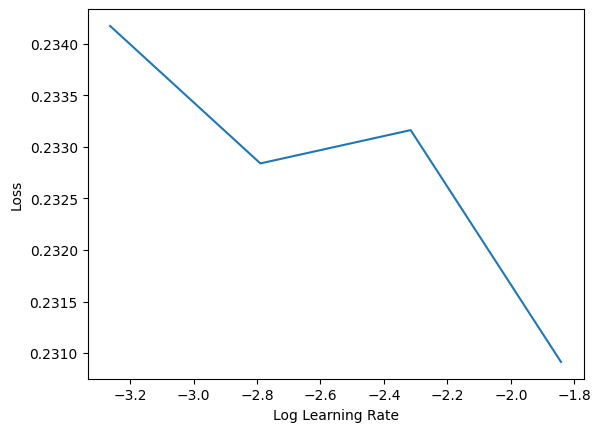

In [27]:
# TODO: cercare pytorch lighning
train_dataset = CustomDataset(train_df, BATCH_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True, drop_last=True)
loss = nn.L1Loss()
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

find_lr(model, train_dataloader, optimizer, loss)

## Training

  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 01/100 | Train Loss 0.176 | Val Loss 0.126
	Saving model (improve loss) 1000000.0 -> 0.12606726586818695
Epoch 02/100 | Train Loss 0.209 | Val Loss 0.138
Epoch 03/100 | Train Loss 0.172 | Val Loss 0.123
	Saving model (improve loss) 0.12606726586818695 -> 0.12279121577739716
Epoch 04/100 | Train Loss 0.209 | Val Loss 0.126
Epoch 05/100 | Train Loss 0.149 | Val Loss 0.111
	Saving model (improve loss) 0.12279121577739716 -> 0.11120488494634628
Epoch 06/100 | Train Loss 0.081 | Val Loss 0.086
	Saving model (improve loss) 0.11120488494634628 -> 0.08603078126907349
Epoch 07/100 | Train Loss 0.080 | Val Loss 0.076
	Saving model (improve loss) 0.08603078126907349 -> 0.07605884969234467
Epoch 08/100 | Train Loss 0.077 | Val Loss 0.073
	Saving model (improve loss) 0.07605884969234467 -> 0.07259576767683029
Epoch 09/100 | Train Loss 0.038 | Val Loss 0.073
Epoch 10/100 | Train Loss 0.066 | Val Loss 0.062
	Saving model (improve loss) 0.07259576767683029 -> 0.06183665245771408
Epoch 11/100 | T

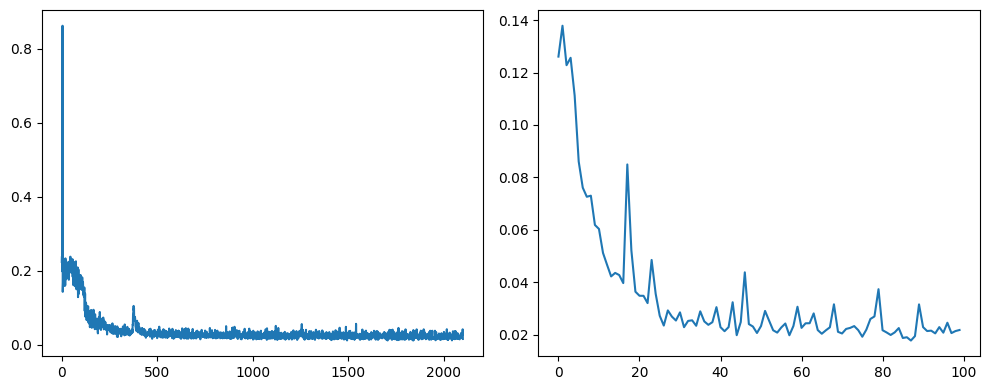

In [19]:
# definizione datasets e dataloaders
# vengono istanziati ogni volta che la run ha inizio così da gestire meglio ed impedire
# errori sul calcolo dei batch
train_dataset = CustomDataset(train_df, BATCH_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_dataset = CustomDataset(val_df, BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

t_loss_list, v_loss_list = [], []
loop = tqdm(range(run.config['epochs']), unit="epoch")
early_stopping = EarlyStopper(patience=20)
best_vloss = 1_000_000.
loss = nn.L1Loss()

run.config['early_stopping'] = str(early_stopping)
run.config['save_best'] = True
run.watch(model)

for epoch in loop:
    model.train()
    for batch_idx, (before, target, future, after, m_b, b_t, m_a, timestamps) in enumerate(train_dataloader):        
        target, before, after, future = target.to(device), before.to(device), after.to(device), future.to(device)
        
        train_pred = model(before, after, future)
        
        train_loss = loss((train_pred/train_pred.sum(dim=(1,2), keepdim=True)) * target.sum(dim=(1,2), keepdim=True), target)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        t_loss_list.append(train_loss.item())
    
    model.eval()
    running_vloss = 0.0
    
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (vbefore, vtarget, vfuture, vafter, vm_b, vm_t, vm_a, vtimestamp) in enumerate(val_dataloader):
            vbefore, vtarget, vfuture, vafter = vbefore.to(device), vtarget.to(device), vfuture.to(device), vafter.to(device)
            voutputs = model(vbefore, vafter, vfuture)
            vloss = loss((voutputs/voutputs.sum(dim=(1,2), keepdim=True)) * vtarget.sum(dim=(1,2), keepdim=True), vtarget)
            running_vloss += vloss

    # resetting dataset generation
    # TODO: fix con DROP LAST
    train_dataset.reset()
    val_dataset.reset()
    
    avg_vloss = running_vloss / (i + 1) # TODO: ricontrollare
    v_loss_list.append(avg_vloss.item())
    
    loop.set_description(f"Epoch [{epoch}/{run.config['epochs']}]")
    loop.set_postfix(loss=t_loss_list[-1], val_loss=v_loss_list[-1])
    
    run.log({"loss": t_loss_list[-1], "val_loss": v_loss_list[-1]})
    
    print(
            f"Epoch {epoch+1:02d}/{run.config['epochs']:02d}"
            f" | Train Loss {t_loss_list[-1]:.3f}"
            f" | Val Loss {v_loss_list[-1]:.3f}"
        )
    
    # save model when improves loss
    if avg_vloss < best_vloss:
        print(f"\tSaving model (improve loss) {best_vloss} -> {avg_vloss}")
        best_vloss = avg_vloss
        model_path = f"GRRUNH_b{run.config['batch_size']}_e{run.config['epochs']}.model"
        torch.save(model.state_dict(), model_path)

    # check for early stopping
    if early_stopping.early_stop(v_loss_list[-1]):
        print(f"\tEarly Stopping @ epoch {epoch} loss: {t_loss_list[-1]} val_loss: {v_loss_list[-1]}")
        break

# plot training/validation loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(t_loss_list)
axes[1].plot(v_loss_list)
fig.tight_layout()

## Evaluation

In [19]:
import plotly.express as px
from torchmetrics.regression import MeanAbsolutePercentageError, SymmetricMeanAbsolutePercentageError, MeanAbsoluteError, R2Score


In [20]:
def MeanImputationError(target, preds):
    return (abs(target-preds)).sum() / target.shape[1]

def NormalizedRootMeanSquareError(target, preds):
    def RootMeanSquareError():
        return np.sqrt((1/target.shape[1]) * torch.pow((target-preds), 2).sum())
    
    RANGE = torch.max(target)-torch.min(target)

    return RootMeanSquareError() / RANGE

In [21]:
model.load_state_dict(torch.load('GRRUNH_b10_e100.model')) # TODO: rendere parametrico il path
model.eval()

NeuralNetwork(
  (input_before): GRU(47, 32, batch_first=True)
  (input_after): GRU(47, 32, batch_first=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1_2): Linear(in_features=64, out_features=128, bias=True)
  (linear2_2): Linear(in_features=128, out_features=128, bias=True)
  (loopGru): GRU(17, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)

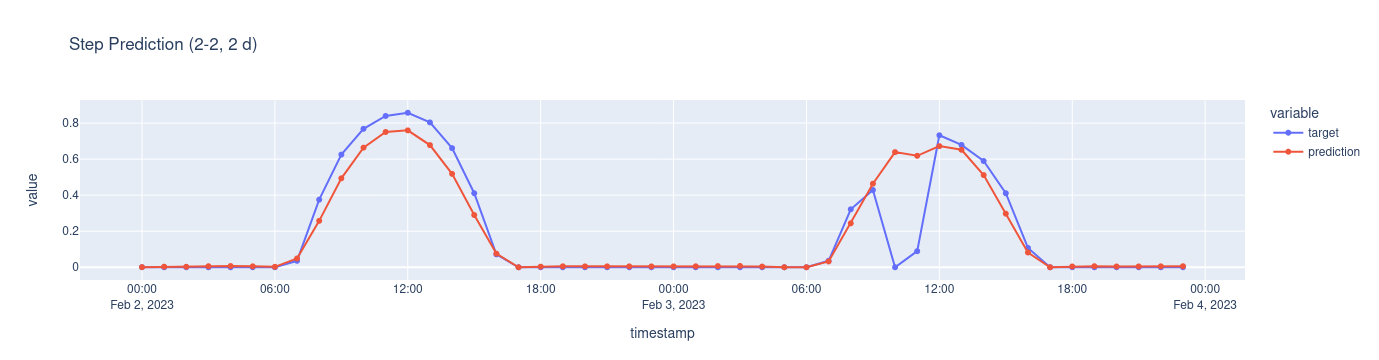

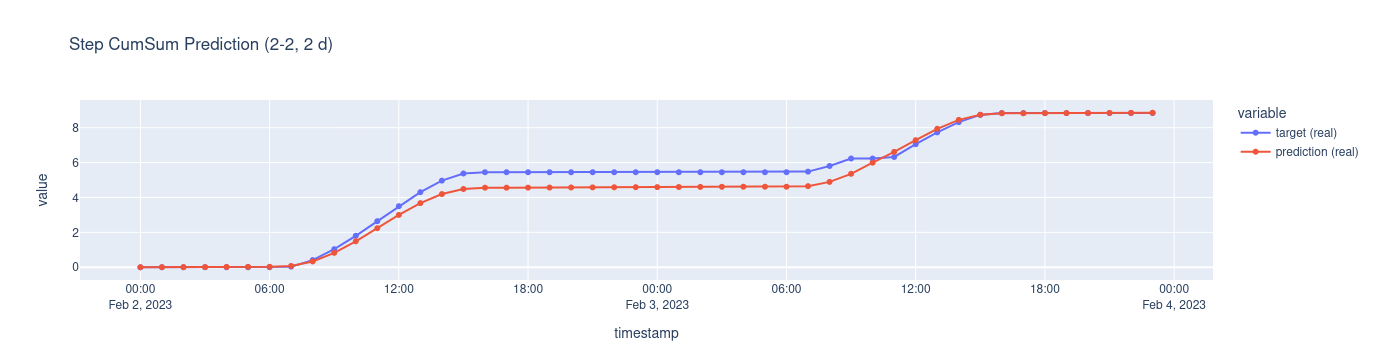

MAPE(+) (2-2): 0.478
SMAPE   (2-2): 1.186
NRMSE   (2-2): 0.153
MAE     (2-2): 0.055
MIE     (2-2): 0.055
R2      (2-2): 0.793
MAE (real): 0.4287337362766266


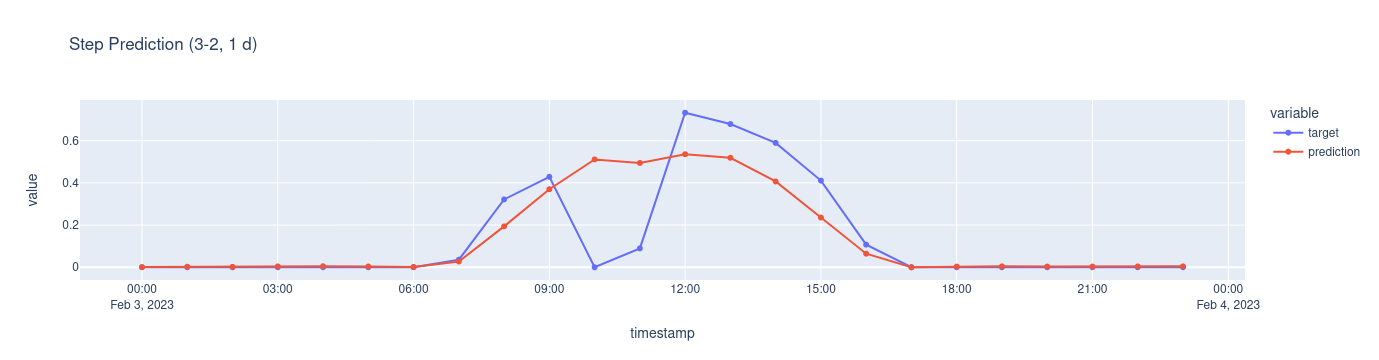

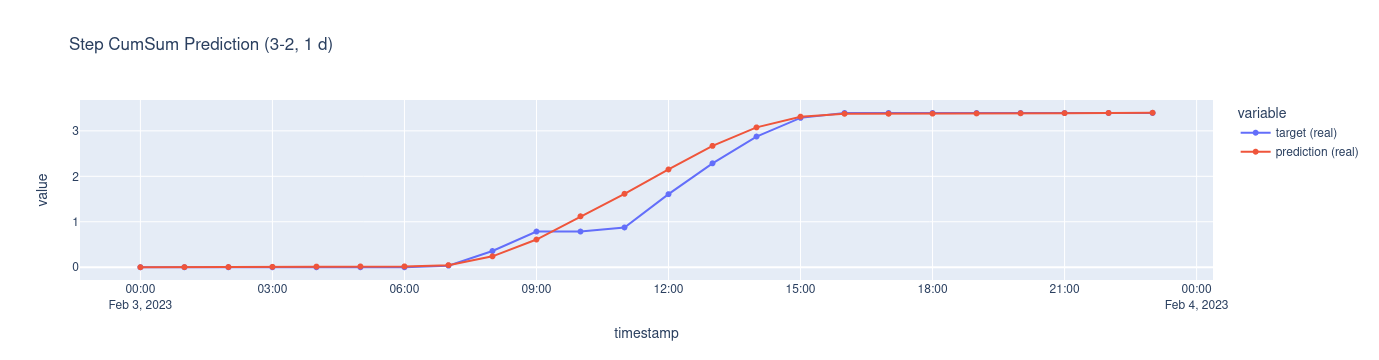

MAPE(+) (3-2): 0.772
SMAPE   (3-2): 1.345
NRMSE   (3-2): 0.211
MAE     (3-2): 0.080
MIE     (3-2): 0.080
R2      (3-2): 0.571
MAE (real): 0.11144807189702988


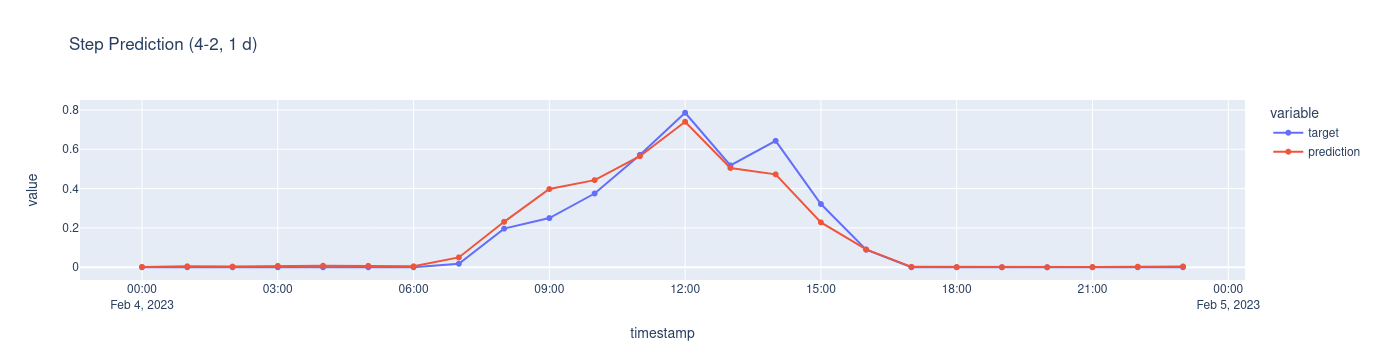

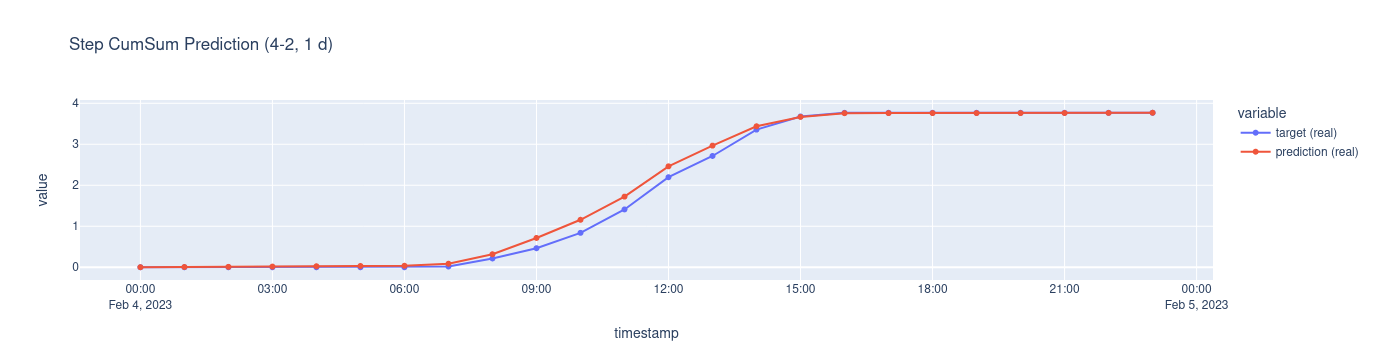

MAPE(+) (4-2): 0.341
SMAPE   (4-2): 1.104
NRMSE   (4-2): 0.0682
MAE     (4-2): 0.027
MIE     (4-2): 0.027
R2      (4-2): 0.950
MAE (real): 0.07644398510456085


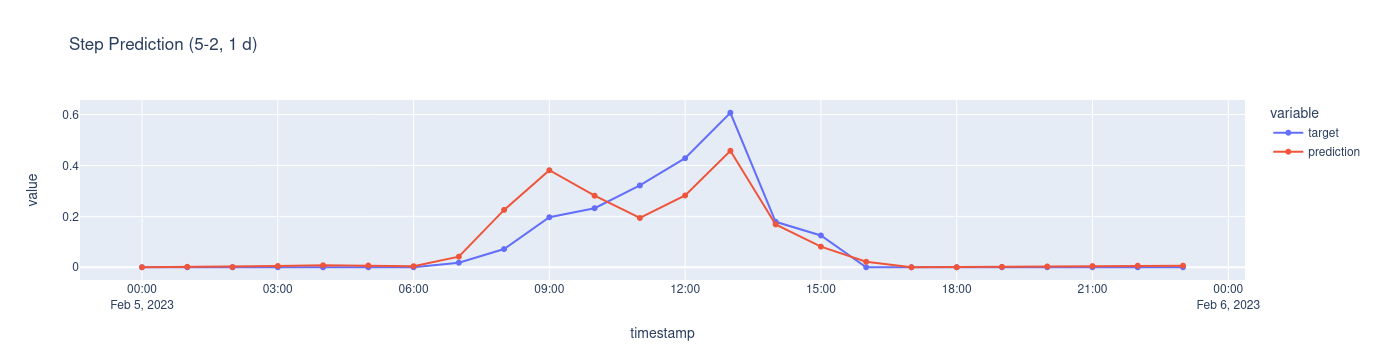

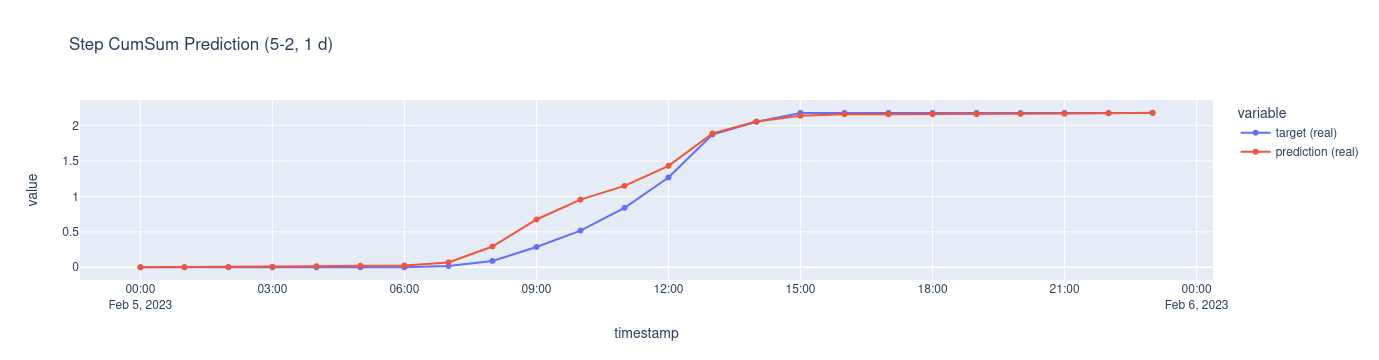

MAPE(+) (5-2): 0.671
SMAPE   (5-2): 1.181
NRMSE   (5-2): 0.118
MAE     (5-2): 0.040
MIE     (5-2): 0.040
R2      (5-2): 0.795
MAE (real): 0.07459232956171036


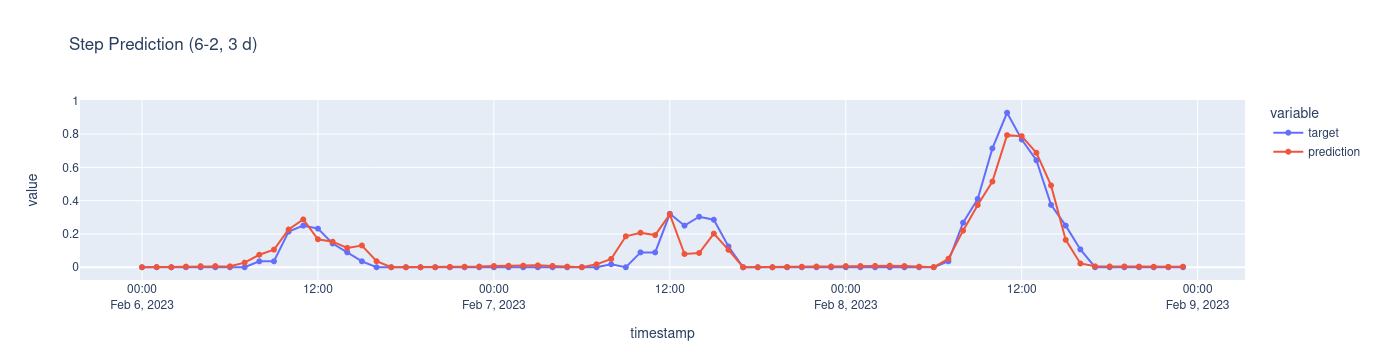

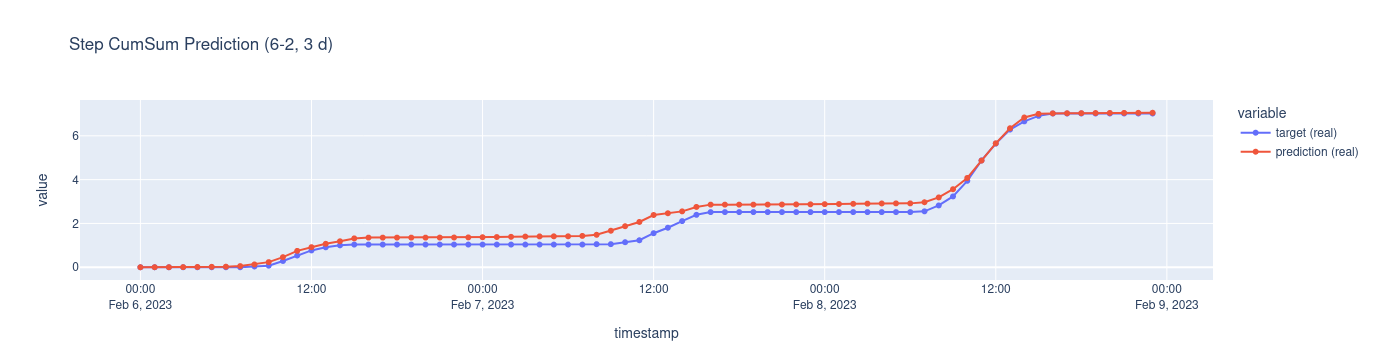

MAPE(+) (6-2): 0.593
SMAPE   (6-2): 1.195
NRMSE   (6-2): 0.065
MAE     (6-2): 0.032
MIE     (6-2): 0.032
R2      (6-2): 0.903
MAE (real): 0.26562440395355225


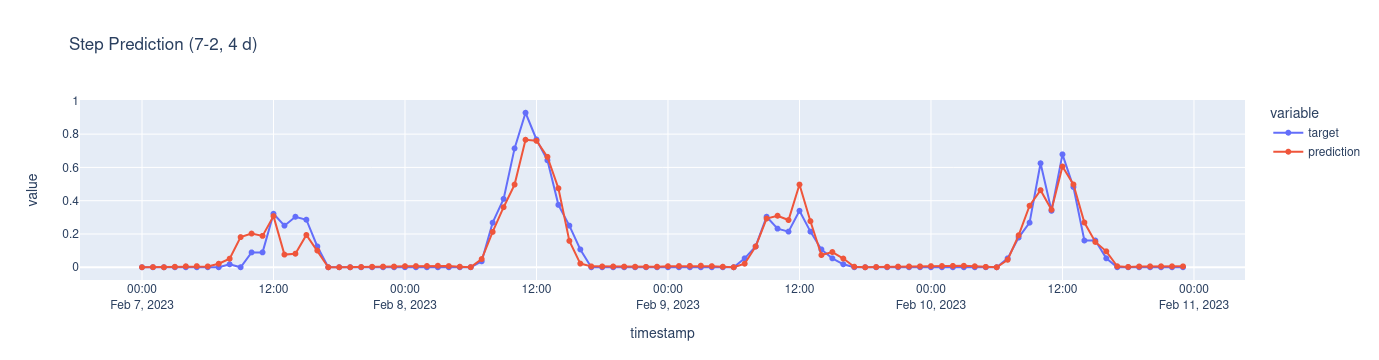

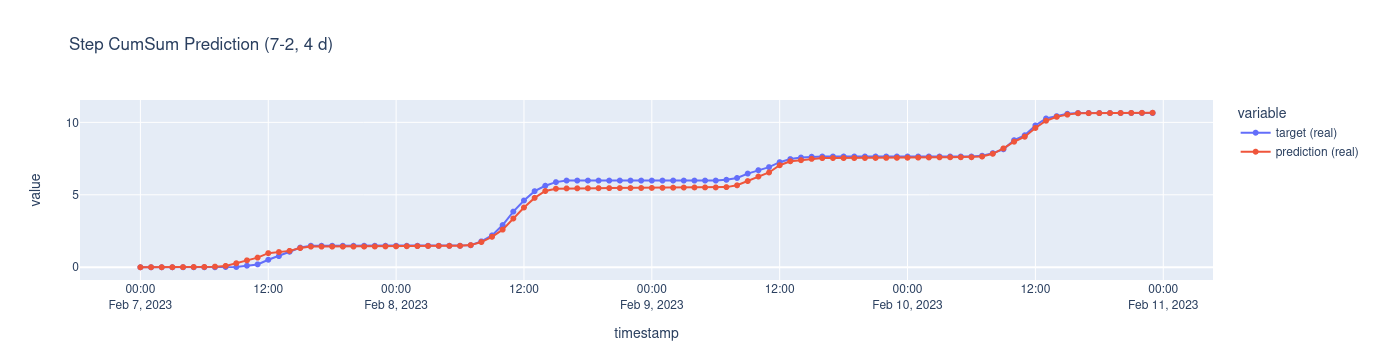

MAPE(+) (7-2): 0.433
SMAPE   (7-2): 1.195
NRMSE   (7-2): 0.0653
MAE     (7-2): 0.032
MIE     (7-2): 0.032
R2      (7-2): 0.906
MAE (real): 0.18838344514369965


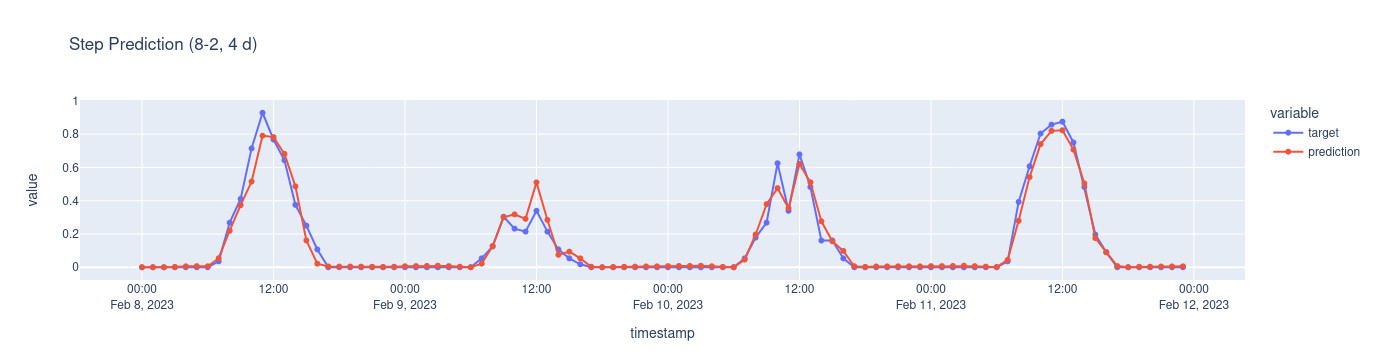

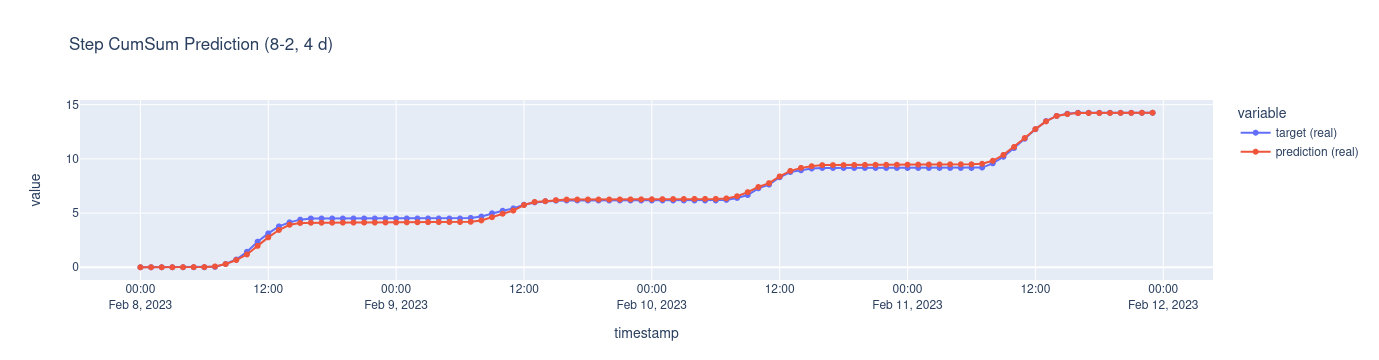

MAPE(+) (8-2): 0.292
SMAPE   (8-2): 1.152
NRMSE   (8-2): 0.0526
MAE     (8-2): 0.027
MIE     (8-2): 0.027
R2      (8-2): 0.962
MAE (real): 0.18640875816345215


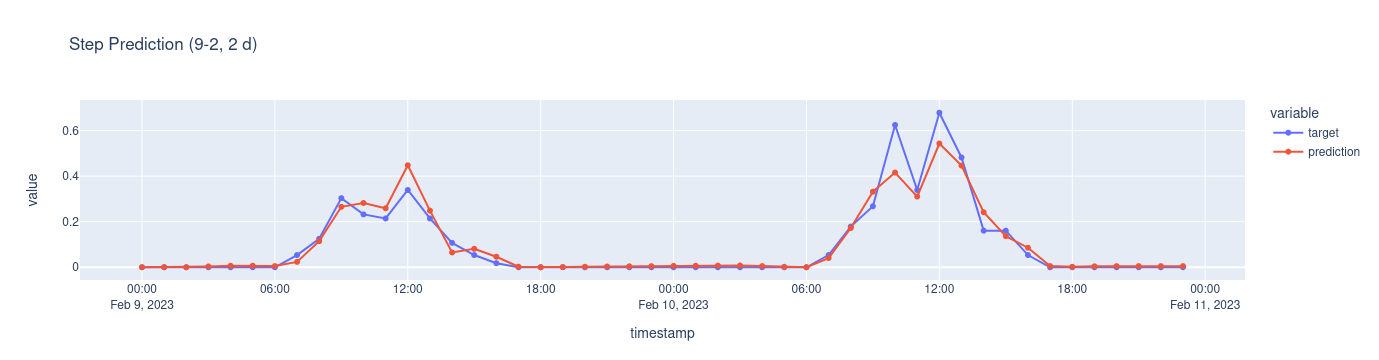

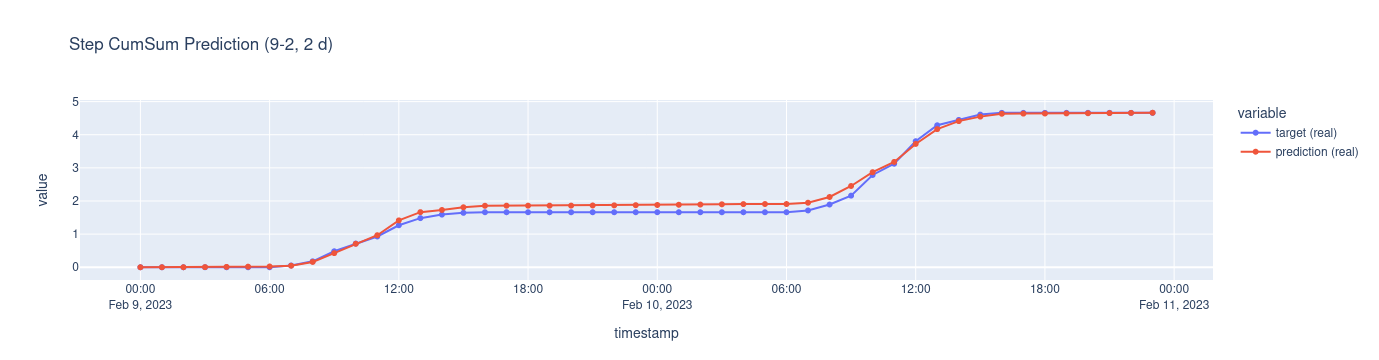

MAPE(+) (9-2): 0.332
SMAPE   (9-2): 1.165
NRMSE   (9-2): 0.0674
MAE     (9-2): 0.024
MIE     (9-2): 0.024
R2      (9-2): 0.922
MAE (real): 0.1121155321598053


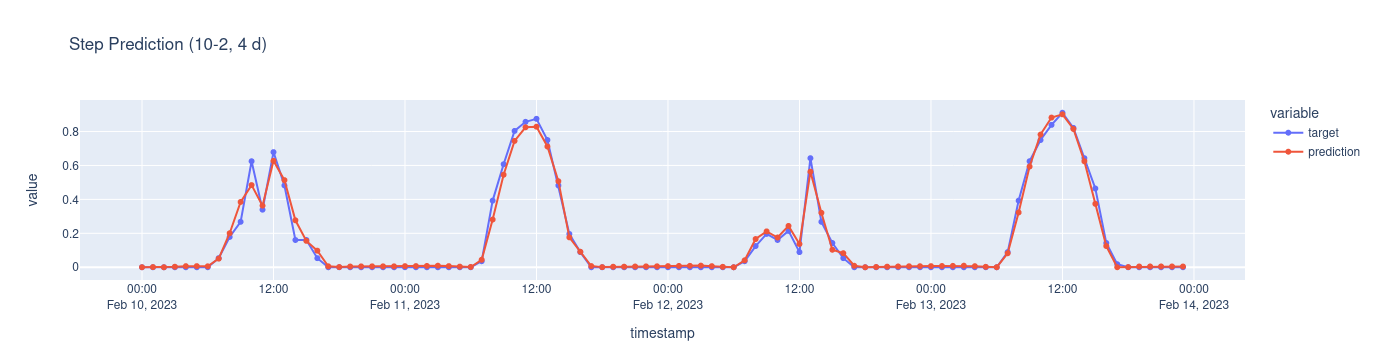

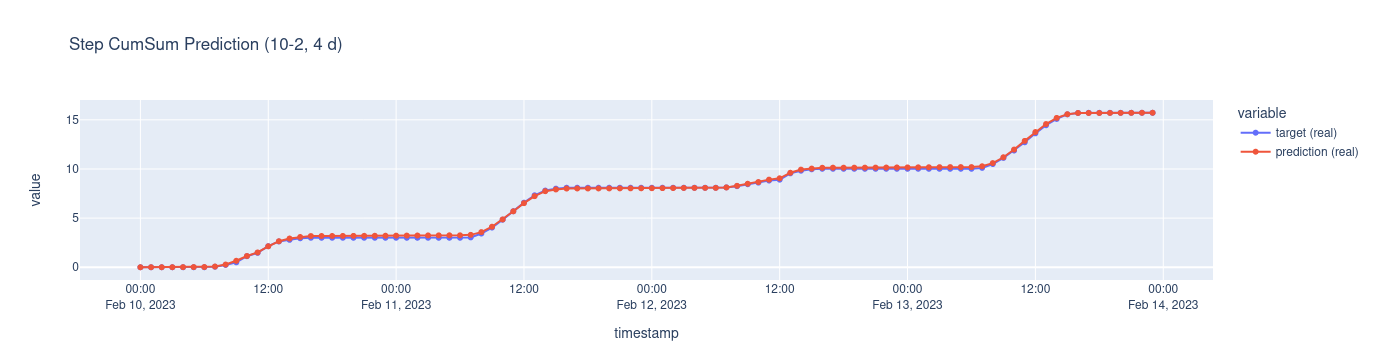

MAPE(+) (10-2): 0.192
SMAPE   (10-2): 1.169
NRMSE   (10-2): 0.0381
MAE     (10-2): 0.020
MIE     (10-2): 0.020
R2      (10-2): 0.983
MAE (real): 0.09493187814950943


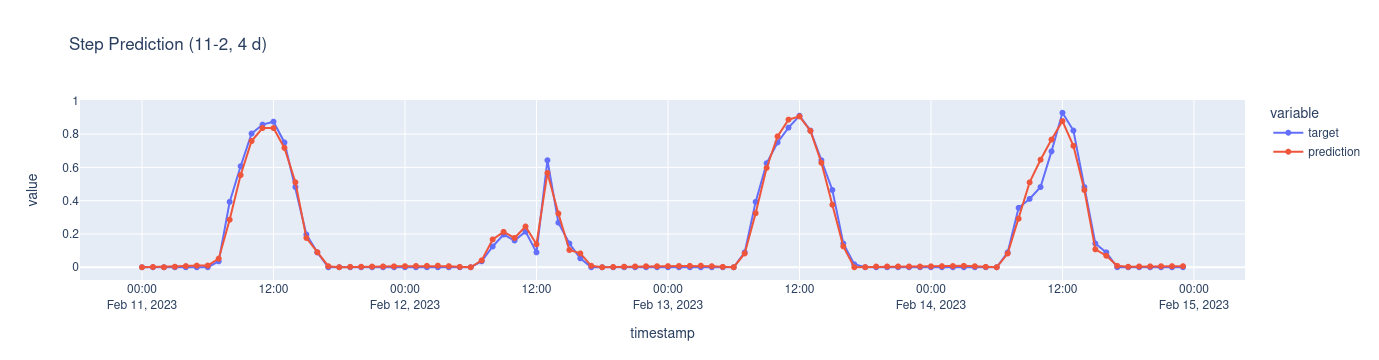

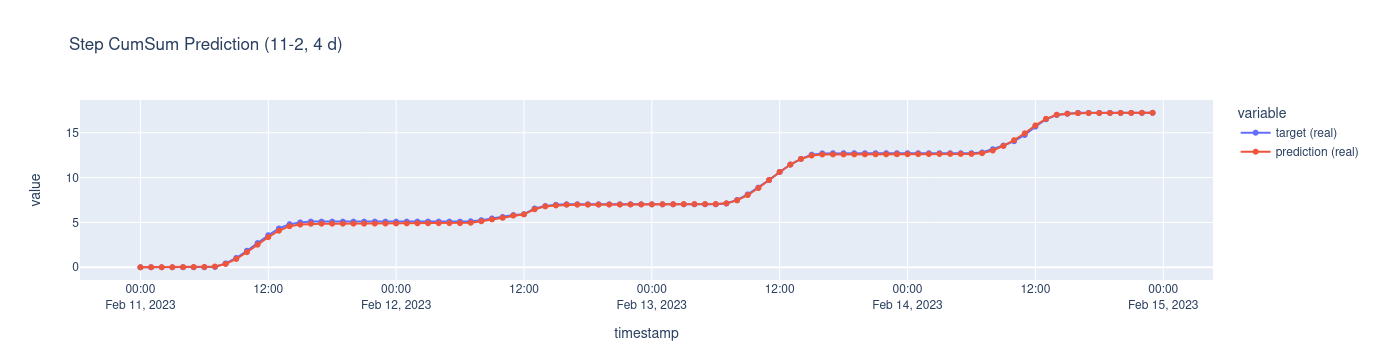

MAPE(+) (11-2): 0.171
SMAPE   (11-2): 1.143
NRMSE   (11-2): 0.0375
MAE     (11-2): 0.020
MIE     (11-2): 0.020
R2      (11-2): 0.985
MAE (real): 0.089418925344944


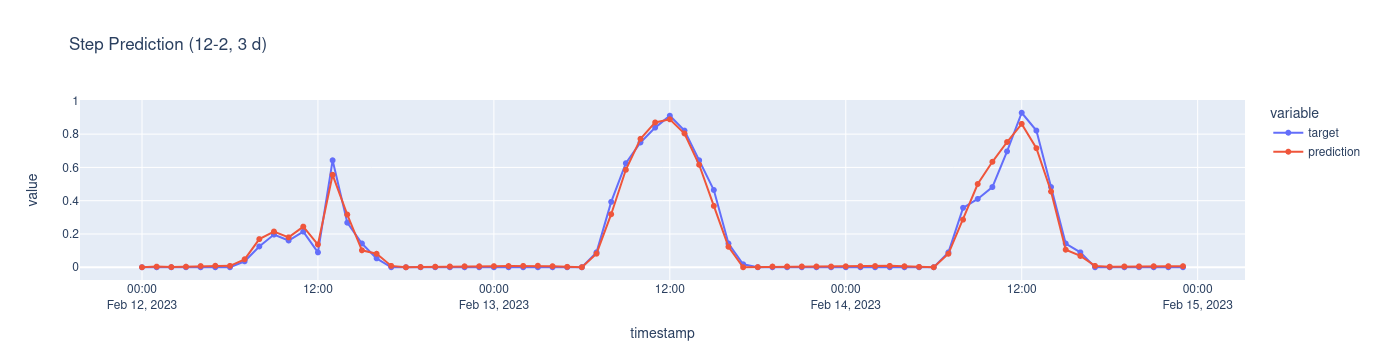

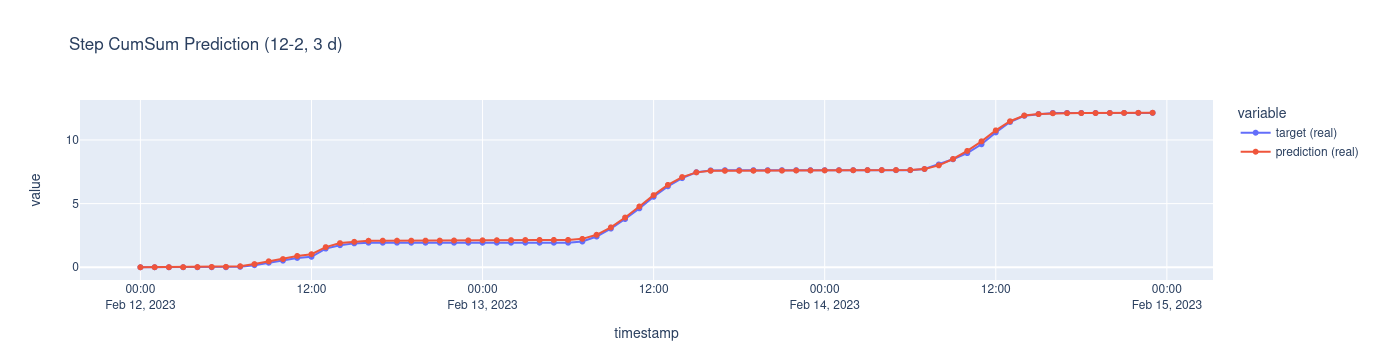

MAPE(+) (12-2): 0.199
SMAPE   (12-2): 1.153
NRMSE   (12-2): 0.0395
MAE     (12-2): 0.022
MIE     (12-2): 0.022
R2      (12-2): 0.982
MAE (real): 0.08685676753520966


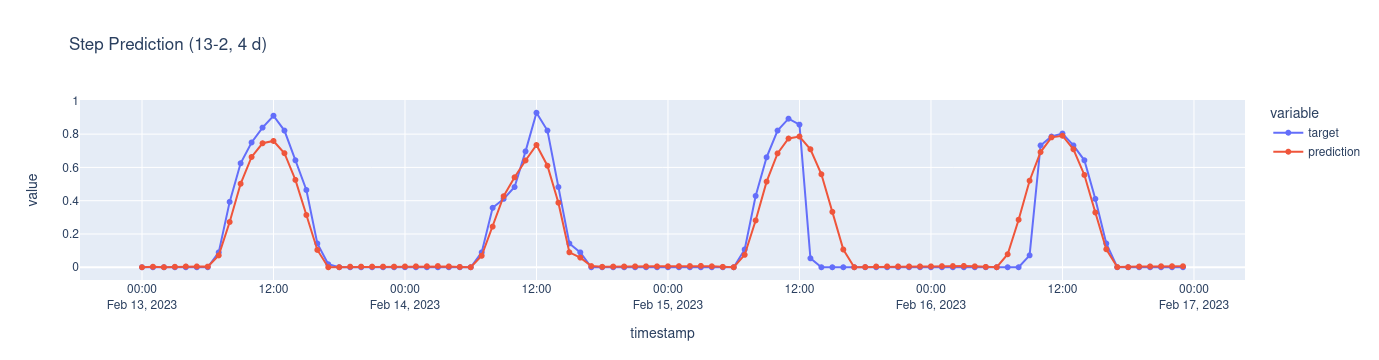

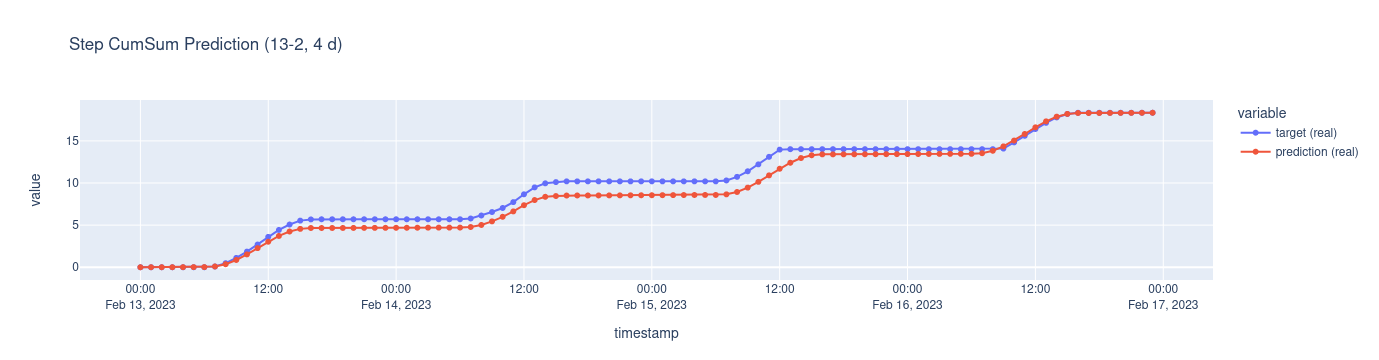

MAPE(+) (13-2): 0.713
SMAPE   (13-2): 1.336
NRMSE   (13-2): 0.134
MAE     (13-2): 0.058
MIE     (13-2): 0.058
R2      (13-2): 0.835
MAE (real): 0.8511936664581299


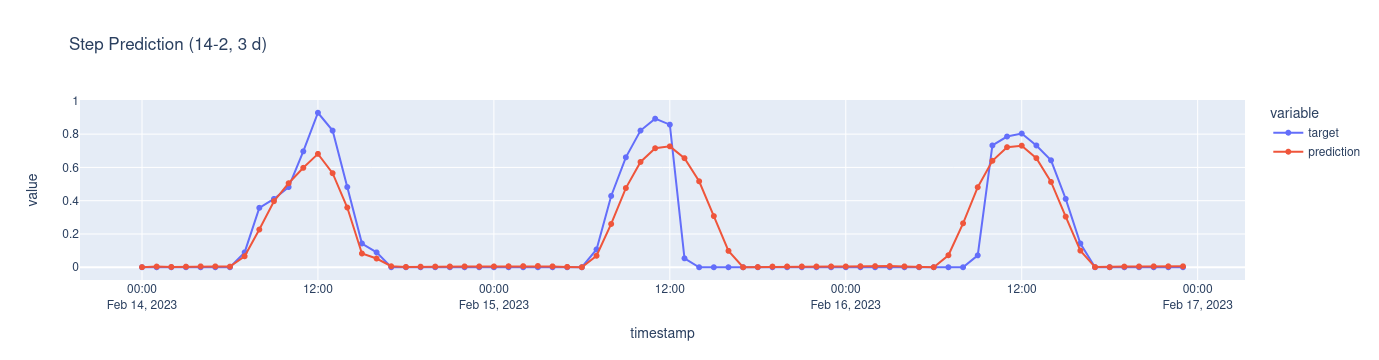

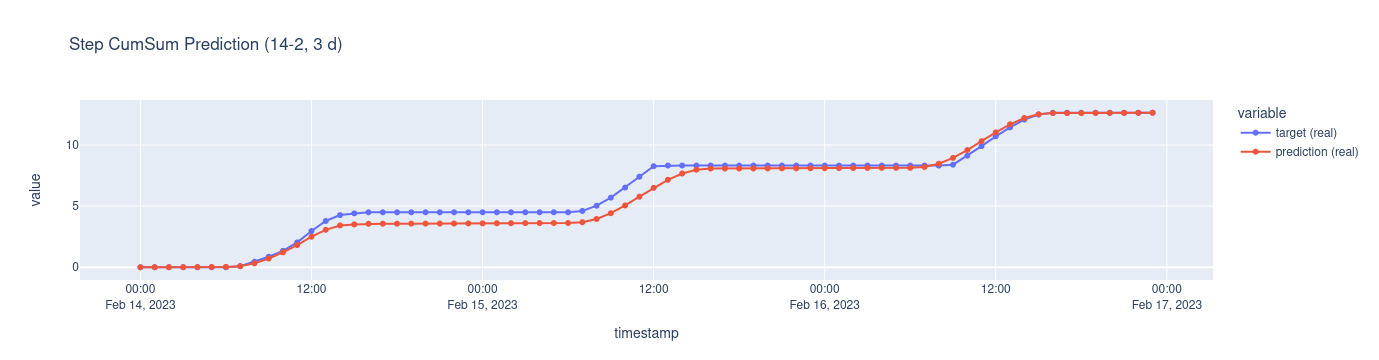

MAPE(+) (14-2): 0.890
SMAPE   (14-2): 1.436
NRMSE   (14-2): 0.148
MAE     (14-2): 0.068
MIE     (14-2): 0.068
R2      (14-2): 0.788
MAE (real): 0.46396562457084656


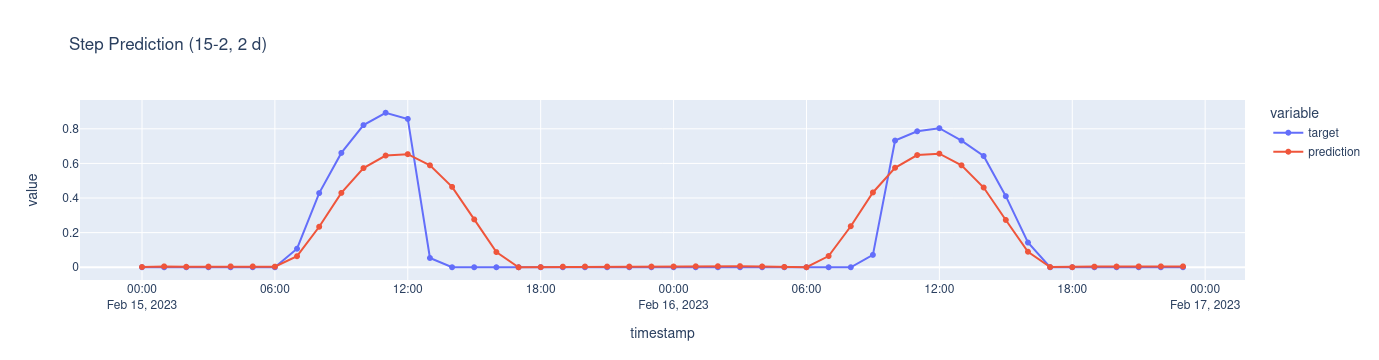

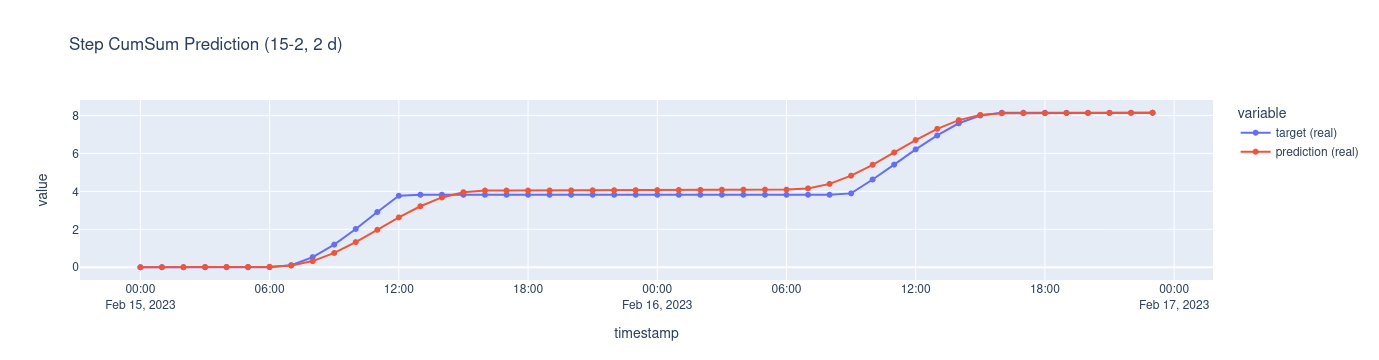

MAPE(+) (15-2): 1.255
SMAPE   (15-2): 1.492
NRMSE   (15-2): 0.175
MAE     (15-2): 0.089
MIE     (15-2): 0.089
R2      (15-2): 0.733
MAE (real): 0.26047542691230774


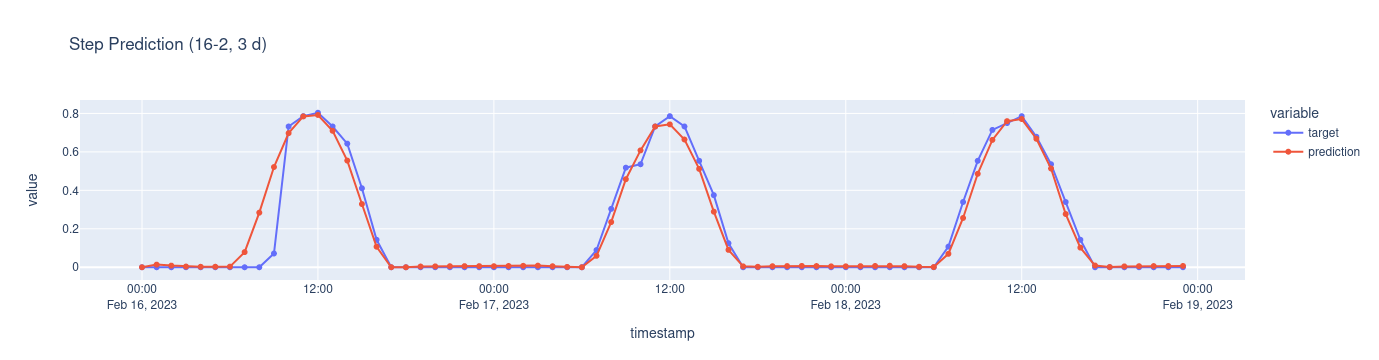

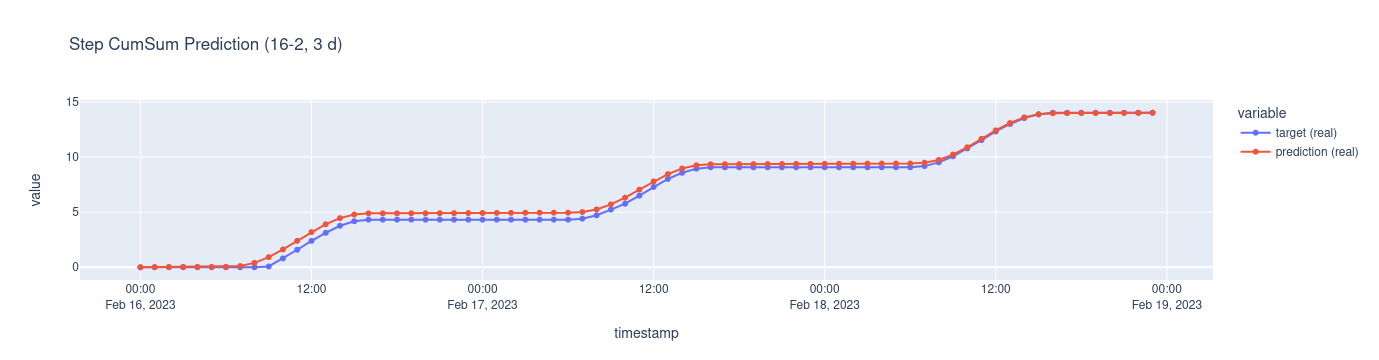

MAPE(+) (16-2): 0.352
SMAPE   (16-2): 1.216
NRMSE   (16-2): 0.0882
MAE     (16-2): 0.031
MIE     (16-2): 0.031
R2      (16-2): 0.940
MAE (real): 0.35060393810272217


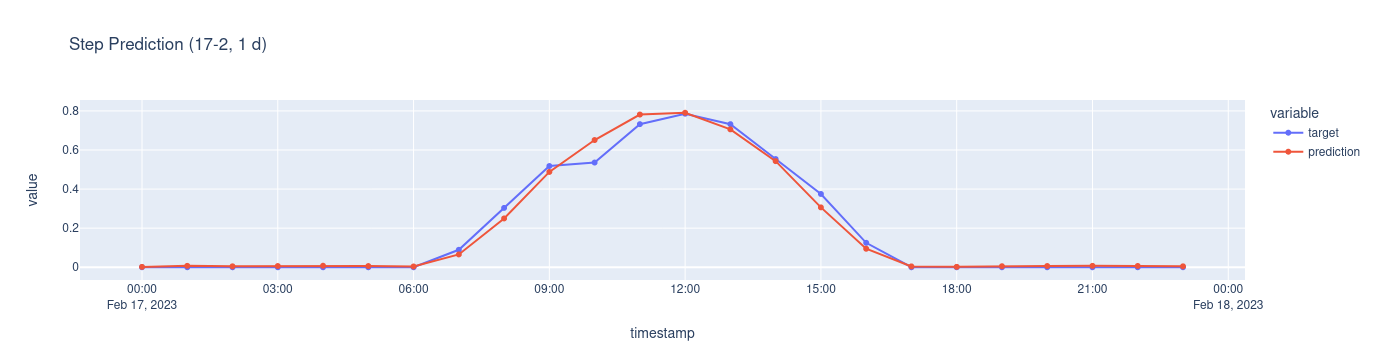

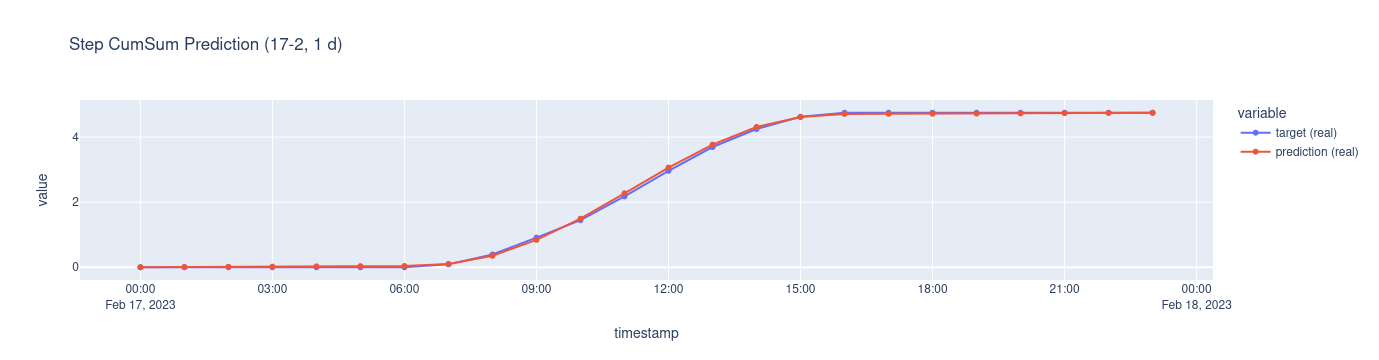

MAPE(+) (17-2): 0.127
SMAPE   (17-2): 1.223
NRMSE   (17-2): 0.0427
MAE     (17-2): 0.020
MIE     (17-2): 0.020
R2      (17-2): 0.986
MAE (real): 0.03365849331021309


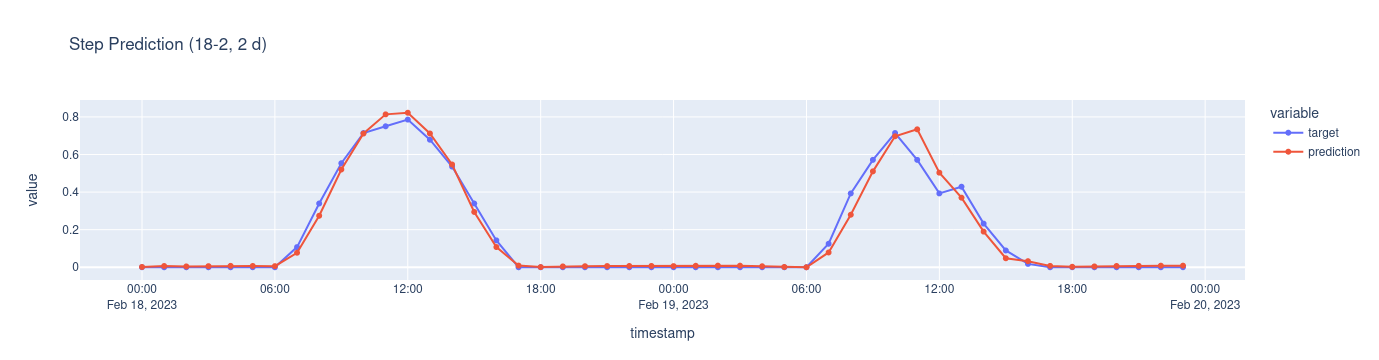

MAPE(+) (18-2): 0.203
SMAPE   (18-2): 1.212
NRMSE   (18-2): 0.0526
MAE     (18-2): 0.025
MIE     (18-2): 0.025
R2      (18-2): 0.975
MAE (real): 0.03696643188595772


MAPE(+) (19-2): 0.290
SMAPE   (19-2): 1.289
NRMSE   (19-2): 0.0739
MAE     (19-2): 0.031
MIE     (19-2): 0.031
R2      (19-2): 0.945
MAE (real): 0.04345345497131348


MAPE(+) (20-2): 0.254
SMAPE   (20-2): 1.104
NRMSE   (20-2): 0.0338
MAE     (20-2): 0.018
MIE     (20-2): 0.018
R2      (20-2): 0.991
MAE (real): 0.03240135684609413


MAPE(+) (21-2): 0.252
SMAPE   (21-2): 1.270
NRMSE   (21-2): 0.0685
MAE     (21-2): 0.034
MIE     (21-2): 0.034
R2      (21-2): 0.953
MAE (real): 0.5547038316726685


MAPE(+) (22-2): 0.337
SMAPE   (22-2): 1.309
NRMSE   (22-2): 0.101
MAE     (22-2): 0.022
MIE     (22-2): 0.022
R2      (22-2): 0.842
MAE (real): 0.031234176829457283


MAPE(+) (23-2): 0.174
SMAPE   (23-2): 1.257
NRMSE   (23-2): 0.0529
MAE     (23-2): 0.026
MIE     (23-2): 0.026
R2      (23-2): 0.977
MAE (real): 0.10682331770658493
Mape Global:  tensor(0.4439)


In [22]:
test_dataset = CustomDataset(test_df, 1)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=collate_fn,
    shuffle=False
)

result = pd.DataFrame()
mean_abs_percentage_error = MeanAbsolutePercentageError()
smape = SymmetricMeanAbsolutePercentageError()
r2 = R2Score()
mae = MeanAbsoluteError()
mie = MeanImputationError
nrmse = NormalizedRootMeanSquareError
mape_points = []
mape = 0

# Create a table
table = wandb.Table(columns = ["Evaluation (on Testing Set)", "MAPE(+)", "SMAPE", "NRMSE", "MAE", "MIE", "R2"])

# Create path for Plotly figure
path_to_plotly_html = "./plotly_figure.html"

for i, (vbefore, vtarget, vfuture, vafter, vm_b, vm_t, vm_a, timestamps) in enumerate(test_dataloader):
    timestamp =  pd.to_datetime(pd.Series(timestamps[0]))
    timestamp = timestamp[vm_t[0] == 1]
        
    vbefore, vafter, vfuture = vbefore.to(device), vafter.to(device), vfuture.to(device)
    prediction = model(vbefore, vafter, vfuture)
    prediction = prediction.cpu().detach()
    prediction = (prediction/prediction.sum(dim=(1,2), keepdim=True)) * vtarget.sum(dim=(1,2), keepdim=True)

    # tutto quello che è < 0 diventa 0
    prediction[prediction < 0] = 0
    
    
    # TODO: ricontrollare mape
    #step_mape = mean_abs_percentage_error(target=vtarget, preds=prediction).item()
    step_mape_positives = mean_abs_percentage_error(target=vtarget[vtarget>0], preds=prediction[vtarget>0])
    step_smape = smape(target=vtarget, preds=prediction)
    step_mae = mae(target=vtarget, preds=prediction)
    step_r2 = r2(target=vtarget.squeeze(0), preds=prediction.squeeze(0))
    step_mie = mie(target=vtarget, preds=prediction)
    step_nrmse = nrmse(target=vtarget, preds=prediction)
    
    #vtarget = vtarget.numpy().reshape(vtarget.shape[1], 1)
    #prediction = prediction.numpy().reshape(prediction.shape[1],1)
    #step_mape_sklearn = mean_absolute_percentage_error(vtarget[vtarget>0], prediction[vtarget>0])
    
    mape_points.append(step_mape_positives)
    mape += step_mape_positives
    
    vtarget = pd.DataFrame(vtarget.numpy().reshape(vtarget.shape[1], 1))
    #vtarget = pd.DataFrame(vtarget)
    vtarget.columns = ['target']
    unnormalized_target = pd.DataFrame((train_target_scaler.inverse_transform(vtarget)).cumsum())
    unnormalized_target.columns = ['target (real)']
    
    prediction = pd.DataFrame(prediction.numpy().reshape(prediction.shape[1],1))
    #prediction = pd.DataFrame(prediction)
    prediction.columns = ['prediction']
    unnormalized_prediction = pd.DataFrame((train_target_scaler.inverse_transform(prediction)).cumsum())
    unnormalized_prediction.columns = ['prediction (real)']
    
    step_result = pd.concat([vtarget, prediction], axis=1)
    step_result.index = timestamp
    step_result_real = pd.concat([unnormalized_target, unnormalized_prediction], axis=1)
    step_result_real.index = timestamp
    
    fig = px.line(step_result, y=['target', 'prediction'], title=f"Step Prediction ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}, {int(np.count_nonzero(vm_t[0]==1)/24)} d)", markers=True)
    fig.write_html(path_to_plotly_html, auto_play=False) 
    fig.show()
    
    fig = px.line(step_result_real, y=['target (real)', 'prediction (real)'], title=f"Step CumSum Prediction ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}, {int(np.count_nonzero(vm_t[0]==1)/24)} d)", markers=True)
    fig.show()

    table.add_data(wandb.Html(path_to_plotly_html), step_mape_positives, step_smape, step_nrmse, step_mae, step_mie, step_r2)

    result =  pd.concat([result, step_result])
    
    print(f"MAPE(+) ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}): {step_mape_positives:.3f}")
    print(f"SMAPE   ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}): {step_smape:.3f}")
    print(f"NRMSE   ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}): {step_nrmse:.3}")
    print(f"MAE     ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}): {step_mae:.3f}")
    print(f"MIE     ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}): {step_mie:.3f}")
    print(f"R2      ({timestamp.dt.day.values[0]}-{timestamp.dt.month.values[0]}): {step_r2:.3f}")
    
    print("MAE (real):", mae(target=torch.tensor(step_result_real['target (real)'].values), preds=torch.tensor(step_result_real['prediction (real)'].values)).item())


print("Mape Global: ", mape/i) # TODO: ricontrollare

# Log Table
run.log({"evluation_table": table})
run.finish()